Este modelo tem uma nova abordagem, tem tudo o que o modelo 1 tem, e mais uma nova abordagem. Basicamento, para minimizar possiveis erros no modelo 1, vamos adicionar mais variabilidade ao introduzirmos um método de score binário. Esta versão é semi-unsupervised final.

In [7]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
import os

def load_and_analyze_data():
    data = load_breast_cancer()
    df = pd.DataFrame(data.data, columns=data.feature_names)
    df['target'] = data.target

    benignos = (df['target'] == 1).sum()
    malignos = (df['target'] == 0).sum()
    total = len(df)

    print(f'Análise do conjunto de dados de câncer de mama:')
    print(f'Número total de amostras: {total}')
    print(f'Número de tumores benignos: {benignos} ({benignos/total:.2%})')
    print(f'Número de tumores malignos: {malignos} ({malignos/total:.2%})')

    #print('\nEstatísticas básicas das características:')
    #print(df.describe())

    return df, data.feature_names

df, feature_names = load_and_analyze_data()

Análise do conjunto de dados de câncer de mama:
Número total de amostras: 569
Número de tumores benignos: 357 (62.74%)
Número de tumores malignos: 212 (37.26%)


In [8]:
def normalize_data(df, feature_names):
    df_normalized = pd.DataFrame()

    for k, col in enumerate(feature_names):
        min_value = k * 10 + 1
        max_value = (k + 1) * 10
        scaler = MinMaxScaler(feature_range=(min_value, max_value))
        df_normalized[f"Normalized_{col}"] = np.floor(scaler.fit_transform(df[col].values.reshape(-1, 1))).astype(int).flatten()

    df_normalized['target'] = df['target']

    return df_normalized

df_normalized = normalize_data(df, feature_names)


print("\nVerificação dos intervalos:")
for col in feature_names:
    normalized_col = f"Normalized_{col}"
    print(f"{normalized_col}: min = {df_normalized[normalized_col].min()}, max = {df_normalized[normalized_col].max()}")


Verificação dos intervalos:
Normalized_mean radius: min = 1, max = 10
Normalized_mean texture: min = 11, max = 20
Normalized_mean perimeter: min = 21, max = 30
Normalized_mean area: min = 31, max = 40
Normalized_mean smoothness: min = 41, max = 50
Normalized_mean compactness: min = 51, max = 60
Normalized_mean concavity: min = 61, max = 70
Normalized_mean concave points: min = 71, max = 80
Normalized_mean symmetry: min = 81, max = 90
Normalized_mean fractal dimension: min = 91, max = 100
Normalized_radius error: min = 101, max = 110
Normalized_texture error: min = 111, max = 120
Normalized_perimeter error: min = 121, max = 130
Normalized_area error: min = 131, max = 140
Normalized_smoothness error: min = 141, max = 150
Normalized_compactness error: min = 151, max = 160
Normalized_concavity error: min = 161, max = 170
Normalized_concave points error: min = 171, max = 180
Normalized_symmetry error: min = 181, max = 190
Normalized_fractal dimension error: min = 191, max = 200
Normalized_

In [9]:
def split_and_save_data(df, filename_prefix='breast_cancer'):
    df_anomalous = df[df['target'] == 0]
    df_normal = df[df['target'] == 1]

    for name, data in [('original', df), ('normal', df_normal), ('anomalous', df_anomalous)]:
        filename = f'{filename_prefix}_{name}.xlsx'
        data.to_excel(filename, index=False)
        print(f"Arquivo '{filename}' salvo com sucesso!")

        print(f"\nInformações do dataset {name}:")
        print(f"Número de amostras: {len(data)}")
        print(f"Número de features: {len(data.columns) - 1}")
        #print("\nPrimeiras linhas do dataset:")
        #print(data.head())
        #print("\nInformações estatísticas básicas:")
        #print(data.describe())

split_and_save_data(df_normalized)

Arquivo 'breast_cancer_original.xlsx' salvo com sucesso!

Informações do dataset original:
Número de amostras: 569
Número de features: 30
Arquivo 'breast_cancer_normal.xlsx' salvo com sucesso!

Informações do dataset normal:
Número de amostras: 357
Número de features: 30
Arquivo 'breast_cancer_anomalous.xlsx' salvo com sucesso!

Informações do dataset anomalous:
Número de amostras: 212
Número de features: 30


In [10]:
import numpy as np
import pandas as pd
import time
import pickle
from tqdm import tqdm

def criar_matriz_detetores(NUM_DETETORES=1000, tamanho=300, seed=42):

    # Fixa a seed para reprodutibilidade
    np.random.seed(seed)
    """Cria uma matriz de detetores aleatórios e sua matriz binária correspondente."""
    matriz_detetores = np.zeros((NUM_DETETORES, tamanho), dtype=int)
    matriz_binaria = np.random.choice([0, 1], size=(NUM_DETETORES, tamanho))

    for i in range(NUM_DETETORES):
        matriz_detetores[i] = np.random.permutation(tamanho) + 1

    return matriz_detetores, matriz_binaria


def load_data(file_path):
    """Carrega os dados do arquivo Excel ou numpy."""
    if file_path.endswith('.xlsx'):
        return pd.read_excel(file_path)
    elif file_path.endswith('.npy'):
        return np.load(file_path)
    else:
        raise ValueError("Formato de arquivo não suportado")

def select_samples(df, percentage):
    num_samples = int(len(df) * percentage)
    return df.iloc[:num_samples]

def create_sublist(samples, detectors, binary_matrices):
    sublists = []
    for i, sample in enumerate(samples):
        sample_values = sample[:-1]
        for j, (detector, binary_matrix) in enumerate(zip(detectors, binary_matrices)):
            positions = [np.where(detector == value)[0][0] for value in sample_values]
            binary_values = binary_matrix[positions]
            sorted_sample = np.array(sample_values)[np.argsort(positions)]
            adjusted_sample = np.where(binary_values == 1, sorted_sample, -sorted_sample)
            sublists.append((i, j, adjusted_sample))
    return sublists

def calculate_score(sublist):
    # Criar a sublista_binaria onde valores positivos são 1 e negativos são 0
    sublista_binaria = (sublist > 0).astype(int)


    # Calcular o score como a conversão binária
    score = sum(val * (2 ** idx) for idx, val in enumerate(sublista_binaria[::-1]))

    return score

def calculate_all_scores(df_samples, detectors, sublists):
    scores = np.zeros((len(df_samples), len(detectors)))
    for i, (_, sample) in enumerate(tqdm(df_samples.iterrows(), total=len(df_samples), desc="Calculando scores")):
        for j, _ in enumerate(detectors):
            sublist = sublists[i * len(detectors) + j][2]
            scores[i, j] = calculate_score(sublist)
    return scores

def select_top_detectors(scores, detectors, binary_matrices, top_n=45):
    # Calcular a performance como a soma total dos scores para cada detector
    n=7
    threshold= sum(2**(29 - i) for i in range(n + 1))
    performance = np.sum(scores >= threshold, axis=0)

    # Selecionar os índices dos top_n detectores com maior performance
    top_indices = np.argsort(performance)[-top_n:][::-1]

    # Selecionar os detectores e matrizes binárias correspondentes
    top_detectors = detectors[top_indices]
    top_binary_matrices = binary_matrices[top_indices]

    return top_indices, top_detectors, top_binary_matrices, performance[top_indices]

def save_to_excel(file_path, detectors, binary_matrices, sheet_name_detectors="Detectores", sheet_name_binary="Binario"):
    with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
        pd.DataFrame(detectors).to_excel(writer, index=False, header=False, sheet_name=sheet_name_detectors)
        pd.DataFrame(binary_matrices).to_excel(writer, index=False, header=False, sheet_name=sheet_name_binary)

In [11]:
import numpy as np
import pandas as pd
import pickle
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

def transform_to_negative_scores(positive_scores):
    """Transforma os scores positivos em negativos."""
    Max_valor=2^30 -1
    return Max_valor - positive_scores

def compute_cumulative_scores(negative_scores):
    """Calcula a soma cumulativa dos scores negativos por amostra."""
    return negative_scores.sum(axis=1)

def calculate_roc_and_detection_rate(normal_scores, anormal_scores, target_fpr=0.1):
    """Calcula a curva ROC e a taxa de detecção para uma FPR específica."""
    labels = np.concatenate([np.zeros(len(normal_scores)), np.ones(len(anormal_scores))])
    scores = np.concatenate([normal_scores, anormal_scores])
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    idx = np.where(fpr <= target_fpr)[0][-1]
    detection_rate = tpr[idx]
    return fpr, tpr, thresholds, roc_auc, detection_rate

def plot_cumulative_scores(normal_cumulative, anormal_cumulative):
    """Plota o gráfico comparativo dos scores cumulativos."""
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 8))
    normal_percentage = np.linspace(0, 100, len(normal_cumulative))
    anormal_percentage = np.linspace(0, 100, len(anormal_cumulative))
    plt.plot(normal_percentage, np.sort(normal_cumulative), label="Normal", marker="o", color="blue", markersize=6, linewidth=2)
    plt.plot(anormal_percentage, np.sort(anormal_cumulative), label="Anormal", marker="s", color="red", markersize=6, linewidth=2)
    plt.xlabel("Percentual de Amostras (%)", fontsize=14, labelpad=10)
    plt.ylabel("Scores Cumulativos", fontsize=14, labelpad=10)
    plt.title("Comparação dos Scores Cumulativos (Normal x Anormal)", fontsize=16, pad=15)
    plt.legend(loc="upper left", fontsize=12, frameon=True, framealpha=0.9, borderpad=1)
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_roc_curve(fpr, tpr, roc_auc, detection_rate):
    """Plota a curva ROC."""
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
    plt.scatter(fpr[np.where(fpr <= 0.1)[0][-1]], tpr[np.where(fpr <= 0.1)[0][-1]],
                color='red', label=f"FPR=10%, TPR={detection_rate:.2f}", zorder=5)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Aleatório (AUC = 0.50)")
    plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=14)
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=14)
    plt.title('Curva ROC', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()


def plot_detection_rates(detection_rates):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(detection_rates) + 1), detection_rates, marker='o', linestyle='-')
    plt.title('Taxa de Detecção por Iteração')
    plt.xlabel('Iteração')
    plt.ylabel('Taxa de Detecção')
    plt.grid(True)
    plt.show()

def main_repeated(n_repeats):
    detection_rates = []
    perfomance_evolutions = []
    for _ in range(n_repeats):
        detection_rate, perfomance_evolution = main()
        detection_rates.append(detection_rate)
        perfomance_evolutions.append(perfomance_evolution)
    return detection_rates, perfomance_evolutions

# Funções para plotar os gráficos
def plot_performance_evolution(performance_evolutions):
    plt.figure(figsize=(10, 6))
    for i, performance in enumerate(performance_evolutions):
        plt.plot(performance, label=f'Repeat {i+1}')
    plt.title('Evolução da Média de Top Performance')
    plt.xlabel('Iterações')
    plt.ylabel('Média de Top Performance')
    plt.legend()
    plt.grid()
    plt.show()

Iterações de treinamento:   0%|          | 0/15 [00:00<?, ?it/s]

primeiros valores de matriz_detetores: [[225  13  81  11 171 281 242  75  28  95 207   3 235  62 284 179  21 294
  154 107  77 104  24 252 151  59   4  78 209  16  89 300 253  52 159 290
  187 125 212  33  84 184   1 176  69  93  97 197 262 173 131  61 288  98
   96  67 198 273 122  35 279 134 161 259  34  92  57 231 106 174  88 162
   42 229 289  22  19 272 239  60 224 255  37 126   6 190 285  50 101 105
  169 168  85 240 256 111 117 127 238 251 112 270  87 260 164 191 257 216
  210 124  12 152   9 102 141  94  49 165 250 120 188 223  23 258 148  51
  206 237 243  46 185 114 109 195  30 121 274 178 145 219 276  10   5  71
  233 138  91 222  54  79 213 146 221 211  65   7 115 155  17   2  36 149
  156 287  47  64 248 192 263 177 297  14 202 182 143 268 261 234 160 214
    8 267 293 299 153 181 264 158 204  80 286 232 144  15 183 116 118 236
  163 166  31 269 220 157 180 283 201  55 167 199 203 295 128 230 228  29
  140 100 227 278  44  66 282 271  99 137 291 266 218 123 133 147 136 208


Iterações de treinamento:   7%|▋         | 1/15 [00:40<09:33, 40.96s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([  -3,   62,  252, -151,  -52,  212,  -84,  262, -173,  131,  161,
         92, -101, -111,  191,   12, -223,   23,  121,  274, -182, -143,
       -232, -283, -203,   44,   73, -245,  -32, -292]))]
primeiros valores de scores_normal_80: [[4.25516056e+08 5.18801579e+08 1.48415014e+08 6.25533430e+08
  3.20385730e+07 7.92555879e+08 4.96485134e+08 6.73142300e+06
  8.31962332e+08 5.24885253e+08 8.43313472e+08 1.45630067e+08
  5.35418612e+08 1.82233740e+08 3.63026517e+08 8.53248588e+08
  1.35766673e+08 5.65003273e+08 2.78376008e+08 5.41472112e+08
  8.94717740e+07 1.62998330e+08 6.44575551e+08 1.61672353e+08
  5.94268386e+08 8.04047225e+08 9.89074712e+08 2.06605514e+08
  6.23370214e+08 1.06537377e+09 1.03394649e+08 7.19741917e+08
  4.67231264e+08 7.47135900e+08 2.78359581e+08 6.62387896e+08
  7.15369368e+08 2.94463600e+08 5.17810445e+08 3.22367133e+08
  7.88857103e+08 1.05812897e+09 6.87850842e+08 8.49332554e+08
  1.15850010e+08 2.3195528


Iterações de treinamento:  13%|█▎        | 2/15 [01:19<08:30, 39.27s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 173,  212,  121,   52,  -32,  232,    3,  -12, -203, -292, -223,
        182,  161,   92, -111,  -62, -131, -283,  143, -101,   44, -151,
        274,   73, -245,  252,   84,   23, -191,  262]))]
primeiros valores de scores_normal_80: [[1.03226032e+09 7.88945111e+08 4.60434777e+08 1.02959375e+09
  8.61695137e+08 1.04865458e+09 1.07318353e+09 5.32779739e+08
  1.06883741e+09 4.36017313e+08 8.59707681e+08 1.06537377e+09
  4.63330566e+08 7.99561344e+08 1.00800998e+09 3.93757132e+08
  3.22413688e+08 7.85284031e+08 6.00771005e+08 1.05812897e+09
  6.67811737e+08 9.35443135e+08 7.69210469e+08 8.05235587e+08
  1.00335537e+09 1.06980381e+09 6.59867963e+08 3.83391793e+08
  7.88248652e+08 1.00577890e+09 5.20412315e+08 1.01645069e+09
  9.39173403e+08 1.07356861e+09 3.33791344e+08 1.91432812e+08
  3.85233576e+08 7.89843839e+08 8.03746192e+08 8.01089229e+08
  7.63635848e+08 3.64239196e+08 6.61038044e+08 4.66201950e+08
  2.40287464e+08 6.7322215


Iterações de treinamento:  20%|██        | 3/15 [01:57<07:47, 38.96s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  1.06400289e+09 1.06325627e+09 2.67474511e+08 1.06014017e+09
  5.37944620e+07 1.03389563e+09 8.61695137e+08 1.04865458e+09
  1.07318353e+09 5.32779739e+08 9.88164831e+08 1.05280050e+09
  4.89729985e+08 1.06537377e+09 8.59707681e+08 1.06883741e+09
  4.36017313e+08 1.01092538e+09 7.99561344e+08 8.48733056e+08
  7.93534395e+08 2.48123961e+08 4.63330566e+08 1.06108647e+09
  3.93757132e+08 1.01066593e+09 1.03349582e+09 1.00800998e+09
  6.00771005e+08 7.85284031e+08 3.22413688e+08 7.81981825e+08
  1.05812897e+09 1.05262237e+09 9.37219142e+08 4.23790297e+08
  1.02955090e+09 8.5468690


Iterações de treinamento:  27%|██▋       | 4/15 [02:35<07:04, 38.59s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 5.37944620e+07 1.03389563e+09
  1.06014017e+09 1.06014017e+09 5.37944620e+07 1.03389563e+09
  8.61695137e+08 5.32779739e+08 1.07318353e+09 1.04865458e+09
  9.88164831e+08 1.05280050e+09 9.88164831e+08 1.05280050e+09
  1.01092538e+09 4.36017313e+08 1.06883741e+09 8.59707681e+08
  1.06537377e+09 4.89729985e+08 1.01092538e+09 4.89729985e+08
  7.93534395e+08 2.48123961e+08 7.93534395e+08 1.06108647e+09
  1.06108647e+09 7.9956134


Iterações de treinamento:  33%|███▎      | 5/15 [03:14<06:27, 38.79s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 2.67474511e+08
  1.06325627e+09 1.06325627e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 1.06014017e+09 5.37944620e+07 1.06014017e+09
  1.03389563e+09 5.37944620e+07 1.03389563e+09 1.06014017e+09
  1.03389563e+09 5.37944620e+07 8.61695137e+08 5.32779739e+08
  1.07318353e+09 1.04865458e+09 9.88164831e+08 1.05280050e+09
  9.88164831e+08 1.05280050e+09 9.88164831e+08 1.05280050e+09
  4.36017313e+08 1.0109253


Iterações de treinamento:  40%|████      | 6/15 [03:52<05:45, 38.33s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  2.67474511e+08 1.06325627e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 2.67474511e+08 1.06325627e+09
  1.03389563e+09 5.37944620e+07 1.03389563e+09 5.37944620e+07
  1.03389563e+09 1.06014017e+09 1.06014017e+09 1.03389563e+09
  1.06014017e+09 5.37944620e+07 1.06014017e+09 5.37944620e+07
  8.61695137e+08 5.3277973


Iterações de treinamento:  47%|████▋     | 7/15 [04:29<05:03, 38.00s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06325627e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 1.06325627e+09 2.67474511e+08 1.03389563e+09
  5.37944620e+07 1.03389563e+09 5.37944620e+07 1.06014017e+09
  5.37944620e+07 1.0601401


Iterações de treinamento:  53%|█████▎    | 8/15 [05:07<04:25, 37.88s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 1.06325627e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.6747451


Iterações de treinamento:  60%|██████    | 9/15 [05:45<03:48, 38.10s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.6747451


Iterações de treinamento:  67%|██████▋   | 10/15 [06:24<03:11, 38.28s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06325627e+09 2.6747451


Iterações de treinamento:  73%|███████▎  | 11/15 [07:02<02:33, 38.35s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.0640028


Iterações de treinamento:  80%|████████  | 12/15 [07:40<01:54, 38.08s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.0640028


Iterações de treinamento:  87%|████████▋ | 13/15 [08:18<01:16, 38.12s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.8169310


Iterações de treinamento:  93%|█████████▎| 14/15 [08:56<00:38, 38.19s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.8169310


Iterações de treinamento: 100%|██████████| 15/15 [09:35<00:00, 38.34s/it]


primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.8169310

Calculando scores: 100%|██████████| 357/357 [00:00<00:00, 1073.22it/s]


primeiros valores de scores_normal_100: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08]]
primeiros valores de sublists_anomalous: [(0, 0, array([ 162,  133, -279,  104,  192,  206,   -5, -112,   77,  -58, -154,
        -67,  227, -173, -266,   34, -183, -246,   25,  -87,

Calculando scores: 100%|██████████| 212/212 [00:00<00:00, 1036.68it/s]


primeiros valores de scores_anomalous: [[9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 1.03787778e+09 3.93617022e+08
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  9.21595784e+08 7.46935867e+08 1.76347690e+08 1.76347690e+08
  1.76347690e+08 1.76347690e+08]]
primeiros valores de negative_scores_normal: [[-1.03302862e+09 -1.03302862e+09 -1.03302862e+09 -1.03302862e+09
  -1.03302862e+09 -1.03302862e+09 -1.03302862e+09 -1.03302862e+09
  -1.0

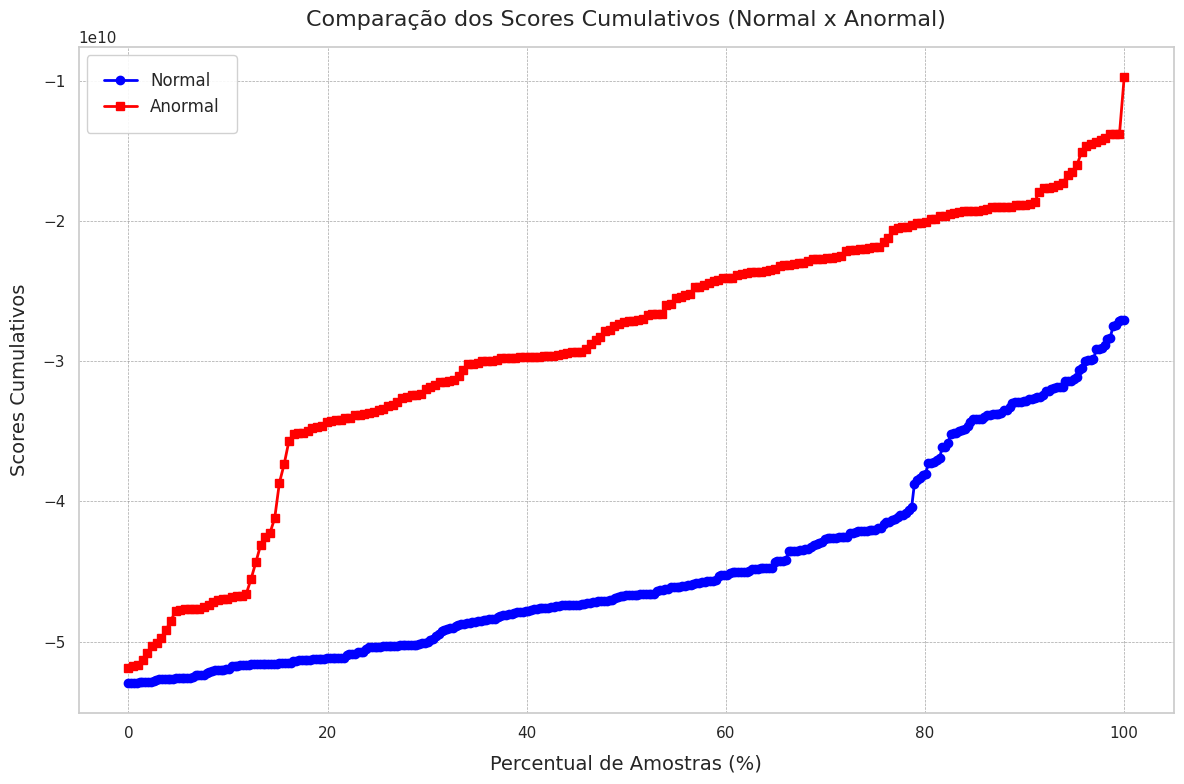

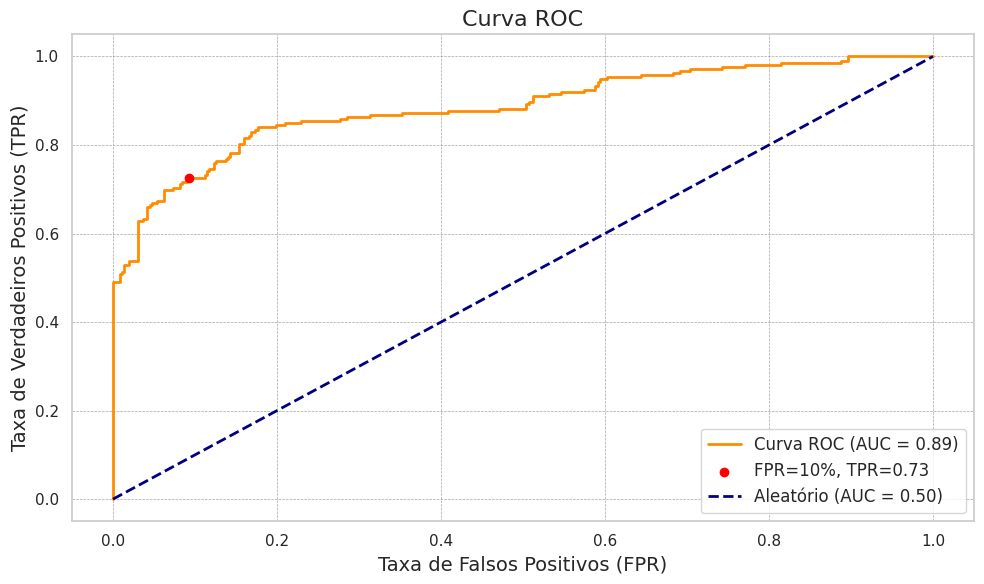

Taxa de detecção para FPR=10%: 72.64%
Tempo total de execução: 581.15 segundos


Iterações de treinamento:   0%|          | 0/15 [00:00<?, ?it/s]

primeiros valores de matriz_detetores: [[225  13  81  11 171 281 242  75  28  95 207   3 235  62 284 179  21 294
  154 107  77 104  24 252 151  59   4  78 209  16  89 300 253  52 159 290
  187 125 212  33  84 184   1 176  69  93  97 197 262 173 131  61 288  98
   96  67 198 273 122  35 279 134 161 259  34  92  57 231 106 174  88 162
   42 229 289  22  19 272 239  60 224 255  37 126   6 190 285  50 101 105
  169 168  85 240 256 111 117 127 238 251 112 270  87 260 164 191 257 216
  210 124  12 152   9 102 141  94  49 165 250 120 188 223  23 258 148  51
  206 237 243  46 185 114 109 195  30 121 274 178 145 219 276  10   5  71
  233 138  91 222  54  79 213 146 221 211  65   7 115 155  17   2  36 149
  156 287  47  64 248 192 263 177 297  14 202 182 143 268 261 234 160 214
    8 267 293 299 153 181 264 158 204  80 286 232 144  15 183 116 118 236
  163 166  31 269 220 157 180 283 201  55 167 199 203 295 128 230 228  29
  140 100 227 278  44  66 282 271  99 137 291 266 218 123 133 147 136 208


Iterações de treinamento:   7%|▋         | 1/15 [00:37<08:50, 37.92s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([  -3,   62,  252, -151,  -52,  212,  -84,  262, -173,  131,  161,
         92, -101, -111,  191,   12, -223,   23,  121,  274, -182, -143,
       -232, -283, -203,   44,   73, -245,  -32, -292]))]
primeiros valores de scores_normal_80: [[4.25516056e+08 5.18801579e+08 1.48415014e+08 6.25533430e+08
  3.20385730e+07 7.92555879e+08 4.96485134e+08 6.73142300e+06
  8.31962332e+08 5.24885253e+08 8.43313472e+08 1.45630067e+08
  5.35418612e+08 1.82233740e+08 3.63026517e+08 8.53248588e+08
  1.35766673e+08 5.65003273e+08 2.78376008e+08 5.41472112e+08
  8.94717740e+07 1.62998330e+08 6.44575551e+08 1.61672353e+08
  5.94268386e+08 8.04047225e+08 9.89074712e+08 2.06605514e+08
  6.23370214e+08 1.06537377e+09 1.03394649e+08 7.19741917e+08
  4.67231264e+08 7.47135900e+08 2.78359581e+08 6.62387896e+08
  7.15369368e+08 2.94463600e+08 5.17810445e+08 3.22367133e+08
  7.88857103e+08 1.05812897e+09 6.87850842e+08 8.49332554e+08
  1.15850010e+08 2.3195528


Iterações de treinamento:  13%|█▎        | 2/15 [01:19<08:40, 40.01s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 173,  212,  121,   52,  -32,  232,    3,  -12, -203, -292, -223,
        182,  161,   92, -111,  -62, -131, -283,  143, -101,   44, -151,
        274,   73, -245,  252,   84,   23, -191,  262]))]
primeiros valores de scores_normal_80: [[1.03226032e+09 7.88945111e+08 4.60434777e+08 1.02959375e+09
  8.61695137e+08 1.04865458e+09 1.07318353e+09 5.32779739e+08
  1.06883741e+09 4.36017313e+08 8.59707681e+08 1.06537377e+09
  4.63330566e+08 7.99561344e+08 1.00800998e+09 3.93757132e+08
  3.22413688e+08 7.85284031e+08 6.00771005e+08 1.05812897e+09
  6.67811737e+08 9.35443135e+08 7.69210469e+08 8.05235587e+08
  1.00335537e+09 1.06980381e+09 6.59867963e+08 3.83391793e+08
  7.88248652e+08 1.00577890e+09 5.20412315e+08 1.01645069e+09
  9.39173403e+08 1.07356861e+09 3.33791344e+08 1.91432812e+08
  3.85233576e+08 7.89843839e+08 8.03746192e+08 8.01089229e+08
  7.63635848e+08 3.64239196e+08 6.61038044e+08 4.66201950e+08
  2.40287464e+08 6.7322215


Iterações de treinamento:  20%|██        | 3/15 [01:58<07:52, 39.40s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  1.06400289e+09 1.06325627e+09 2.67474511e+08 1.06014017e+09
  5.37944620e+07 1.03389563e+09 8.61695137e+08 1.04865458e+09
  1.07318353e+09 5.32779739e+08 9.88164831e+08 1.05280050e+09
  4.89729985e+08 1.06537377e+09 8.59707681e+08 1.06883741e+09
  4.36017313e+08 1.01092538e+09 7.99561344e+08 8.48733056e+08
  7.93534395e+08 2.48123961e+08 4.63330566e+08 1.06108647e+09
  3.93757132e+08 1.01066593e+09 1.03349582e+09 1.00800998e+09
  6.00771005e+08 7.85284031e+08 3.22413688e+08 7.81981825e+08
  1.05812897e+09 1.05262237e+09 9.37219142e+08 4.23790297e+08
  1.02955090e+09 8.5468690


Iterações de treinamento:  27%|██▋       | 4/15 [02:36<07:08, 38.96s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 5.37944620e+07 1.03389563e+09
  1.06014017e+09 1.06014017e+09 5.37944620e+07 1.03389563e+09
  8.61695137e+08 5.32779739e+08 1.07318353e+09 1.04865458e+09
  9.88164831e+08 1.05280050e+09 9.88164831e+08 1.05280050e+09
  1.01092538e+09 4.36017313e+08 1.06883741e+09 8.59707681e+08
  1.06537377e+09 4.89729985e+08 1.01092538e+09 4.89729985e+08
  7.93534395e+08 2.48123961e+08 7.93534395e+08 1.06108647e+09
  1.06108647e+09 7.9956134


Iterações de treinamento:  33%|███▎      | 5/15 [03:14<06:27, 38.71s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 2.67474511e+08
  1.06325627e+09 1.06325627e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 1.06014017e+09 5.37944620e+07 1.06014017e+09
  1.03389563e+09 5.37944620e+07 1.03389563e+09 1.06014017e+09
  1.03389563e+09 5.37944620e+07 8.61695137e+08 5.32779739e+08
  1.07318353e+09 1.04865458e+09 9.88164831e+08 1.05280050e+09
  9.88164831e+08 1.05280050e+09 9.88164831e+08 1.05280050e+09
  4.36017313e+08 1.0109253


Iterações de treinamento:  40%|████      | 6/15 [03:53<05:47, 38.64s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  2.67474511e+08 1.06325627e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 2.67474511e+08 1.06325627e+09
  1.03389563e+09 5.37944620e+07 1.03389563e+09 5.37944620e+07
  1.03389563e+09 1.06014017e+09 1.06014017e+09 1.03389563e+09
  1.06014017e+09 5.37944620e+07 1.06014017e+09 5.37944620e+07
  8.61695137e+08 5.3277973


Iterações de treinamento:  47%|████▋     | 7/15 [04:31<05:07, 38.40s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06325627e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 1.06325627e+09 2.67474511e+08 1.03389563e+09
  5.37944620e+07 1.03389563e+09 5.37944620e+07 1.06014017e+09
  5.37944620e+07 1.0601401


Iterações de treinamento:  53%|█████▎    | 8/15 [05:09<04:29, 38.52s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 1.06325627e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.6747451


Iterações de treinamento:  60%|██████    | 9/15 [05:48<03:51, 38.52s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.6747451


Iterações de treinamento:  67%|██████▋   | 10/15 [06:27<03:12, 38.58s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06325627e+09 2.6747451


Iterações de treinamento:  73%|███████▎  | 11/15 [07:04<02:32, 38.21s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.0640028


Iterações de treinamento:  80%|████████  | 12/15 [07:43<01:55, 38.34s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.0640028


Iterações de treinamento:  87%|████████▋ | 13/15 [08:21<01:16, 38.47s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.8169310


Iterações de treinamento:  93%|█████████▎| 14/15 [09:00<00:38, 38.50s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.8169310


Iterações de treinamento: 100%|██████████| 15/15 [09:38<00:00, 38.59s/it]


primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.8169310

Calculando scores: 100%|██████████| 357/357 [00:00<00:00, 1038.52it/s]


primeiros valores de scores_normal_100: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08]]
primeiros valores de sublists_anomalous: [(0, 0, array([ 162,  133, -279,  104,  192,  206,   -5, -112,   77,  -58, -154,
        -67,  227, -173, -266,   34, -183, -246,   25,  -87,

Calculando scores: 100%|██████████| 212/212 [00:00<00:00, 991.62it/s] 


primeiros valores de scores_anomalous: [[9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 1.03787778e+09 3.93617022e+08
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  9.21595784e+08 7.46935867e+08 1.76347690e+08 1.76347690e+08
  1.76347690e+08 1.76347690e+08]]
primeiros valores de negative_scores_normal: [[-1.03302862e+09 -1.03302862e+09 -1.03302862e+09 -1.03302862e+09
  -1.03302862e+09 -1.03302862e+09 -1.03302862e+09 -1.03302862e+09
  -1.0

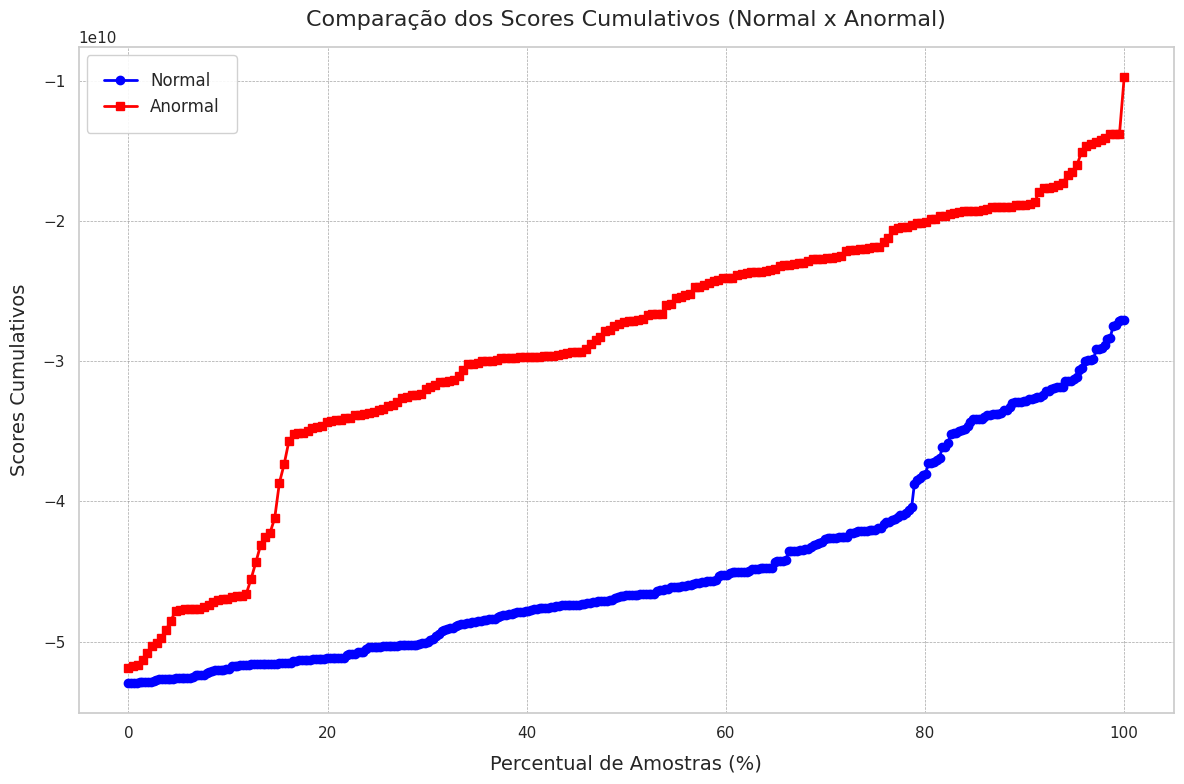

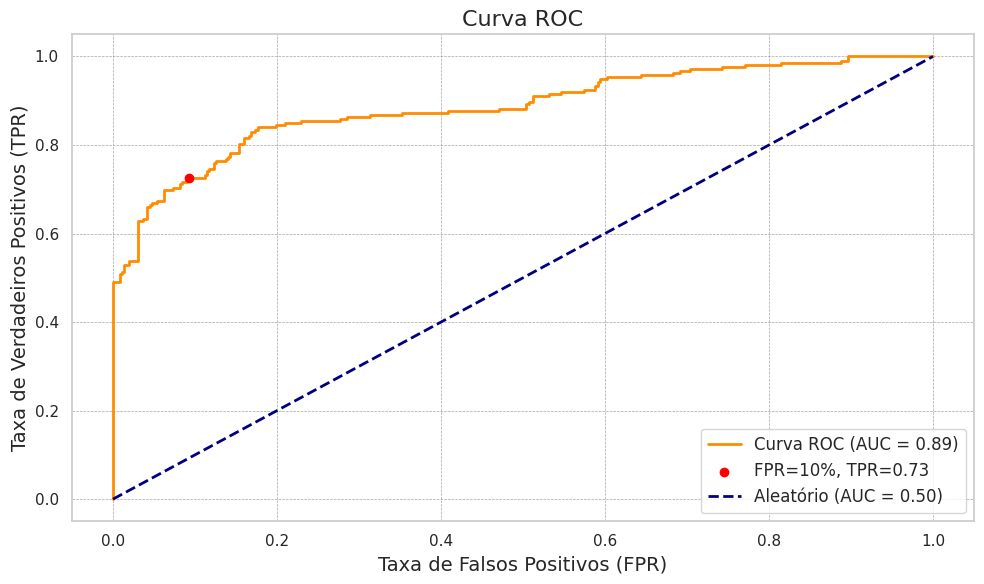

Taxa de detecção para FPR=10%: 72.64%
Tempo total de execução: 584.83 segundos


Iterações de treinamento:   0%|          | 0/15 [00:00<?, ?it/s]

primeiros valores de matriz_detetores: [[225  13  81  11 171 281 242  75  28  95 207   3 235  62 284 179  21 294
  154 107  77 104  24 252 151  59   4  78 209  16  89 300 253  52 159 290
  187 125 212  33  84 184   1 176  69  93  97 197 262 173 131  61 288  98
   96  67 198 273 122  35 279 134 161 259  34  92  57 231 106 174  88 162
   42 229 289  22  19 272 239  60 224 255  37 126   6 190 285  50 101 105
  169 168  85 240 256 111 117 127 238 251 112 270  87 260 164 191 257 216
  210 124  12 152   9 102 141  94  49 165 250 120 188 223  23 258 148  51
  206 237 243  46 185 114 109 195  30 121 274 178 145 219 276  10   5  71
  233 138  91 222  54  79 213 146 221 211  65   7 115 155  17   2  36 149
  156 287  47  64 248 192 263 177 297  14 202 182 143 268 261 234 160 214
    8 267 293 299 153 181 264 158 204  80 286 232 144  15 183 116 118 236
  163 166  31 269 220 157 180 283 201  55 167 199 203 295 128 230 228  29
  140 100 227 278  44  66 282 271  99 137 291 266 218 123 133 147 136 208


Iterações de treinamento:   7%|▋         | 1/15 [00:40<09:28, 40.60s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([  -3,   62,  252, -151,  -52,  212,  -84,  262, -173,  131,  161,
         92, -101, -111,  191,   12, -223,   23,  121,  274, -182, -143,
       -232, -283, -203,   44,   73, -245,  -32, -292]))]
primeiros valores de scores_normal_80: [[4.25516056e+08 5.18801579e+08 1.48415014e+08 6.25533430e+08
  3.20385730e+07 7.92555879e+08 4.96485134e+08 6.73142300e+06
  8.31962332e+08 5.24885253e+08 8.43313472e+08 1.45630067e+08
  5.35418612e+08 1.82233740e+08 3.63026517e+08 8.53248588e+08
  1.35766673e+08 5.65003273e+08 2.78376008e+08 5.41472112e+08
  8.94717740e+07 1.62998330e+08 6.44575551e+08 1.61672353e+08
  5.94268386e+08 8.04047225e+08 9.89074712e+08 2.06605514e+08
  6.23370214e+08 1.06537377e+09 1.03394649e+08 7.19741917e+08
  4.67231264e+08 7.47135900e+08 2.78359581e+08 6.62387896e+08
  7.15369368e+08 2.94463600e+08 5.17810445e+08 3.22367133e+08
  7.88857103e+08 1.05812897e+09 6.87850842e+08 8.49332554e+08
  1.15850010e+08 2.3195528


Iterações de treinamento:  13%|█▎        | 2/15 [01:19<08:36, 39.74s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 173,  212,  121,   52,  -32,  232,    3,  -12, -203, -292, -223,
        182,  161,   92, -111,  -62, -131, -283,  143, -101,   44, -151,
        274,   73, -245,  252,   84,   23, -191,  262]))]
primeiros valores de scores_normal_80: [[1.03226032e+09 7.88945111e+08 4.60434777e+08 1.02959375e+09
  8.61695137e+08 1.04865458e+09 1.07318353e+09 5.32779739e+08
  1.06883741e+09 4.36017313e+08 8.59707681e+08 1.06537377e+09
  4.63330566e+08 7.99561344e+08 1.00800998e+09 3.93757132e+08
  3.22413688e+08 7.85284031e+08 6.00771005e+08 1.05812897e+09
  6.67811737e+08 9.35443135e+08 7.69210469e+08 8.05235587e+08
  1.00335537e+09 1.06980381e+09 6.59867963e+08 3.83391793e+08
  7.88248652e+08 1.00577890e+09 5.20412315e+08 1.01645069e+09
  9.39173403e+08 1.07356861e+09 3.33791344e+08 1.91432812e+08
  3.85233576e+08 7.89843839e+08 8.03746192e+08 8.01089229e+08
  7.63635848e+08 3.64239196e+08 6.61038044e+08 4.66201950e+08
  2.40287464e+08 6.7322215


Iterações de treinamento:  20%|██        | 3/15 [01:58<07:53, 39.50s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  1.06400289e+09 1.06325627e+09 2.67474511e+08 1.06014017e+09
  5.37944620e+07 1.03389563e+09 8.61695137e+08 1.04865458e+09
  1.07318353e+09 5.32779739e+08 9.88164831e+08 1.05280050e+09
  4.89729985e+08 1.06537377e+09 8.59707681e+08 1.06883741e+09
  4.36017313e+08 1.01092538e+09 7.99561344e+08 8.48733056e+08
  7.93534395e+08 2.48123961e+08 4.63330566e+08 1.06108647e+09
  3.93757132e+08 1.01066593e+09 1.03349582e+09 1.00800998e+09
  6.00771005e+08 7.85284031e+08 3.22413688e+08 7.81981825e+08
  1.05812897e+09 1.05262237e+09 9.37219142e+08 4.23790297e+08
  1.02955090e+09 8.5468690


Iterações de treinamento:  27%|██▋       | 4/15 [02:38<07:14, 39.47s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 5.37944620e+07 1.03389563e+09
  1.06014017e+09 1.06014017e+09 5.37944620e+07 1.03389563e+09
  8.61695137e+08 5.32779739e+08 1.07318353e+09 1.04865458e+09
  9.88164831e+08 1.05280050e+09 9.88164831e+08 1.05280050e+09
  1.01092538e+09 4.36017313e+08 1.06883741e+09 8.59707681e+08
  1.06537377e+09 4.89729985e+08 1.01092538e+09 4.89729985e+08
  7.93534395e+08 2.48123961e+08 7.93534395e+08 1.06108647e+09
  1.06108647e+09 7.9956134


Iterações de treinamento:  33%|███▎      | 5/15 [03:18<06:35, 39.59s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 2.67474511e+08
  1.06325627e+09 1.06325627e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 1.06014017e+09 5.37944620e+07 1.06014017e+09
  1.03389563e+09 5.37944620e+07 1.03389563e+09 1.06014017e+09
  1.03389563e+09 5.37944620e+07 8.61695137e+08 5.32779739e+08
  1.07318353e+09 1.04865458e+09 9.88164831e+08 1.05280050e+09
  9.88164831e+08 1.05280050e+09 9.88164831e+08 1.05280050e+09
  4.36017313e+08 1.0109253


Iterações de treinamento:  40%|████      | 6/15 [03:57<05:56, 39.63s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  2.67474511e+08 1.06325627e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 2.67474511e+08 1.06325627e+09
  1.03389563e+09 5.37944620e+07 1.03389563e+09 5.37944620e+07
  1.03389563e+09 1.06014017e+09 1.06014017e+09 1.03389563e+09
  1.06014017e+09 5.37944620e+07 1.06014017e+09 5.37944620e+07
  8.61695137e+08 5.3277973


Iterações de treinamento:  47%|████▋     | 7/15 [04:37<05:16, 39.61s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06325627e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 1.06325627e+09 2.67474511e+08 1.03389563e+09
  5.37944620e+07 1.03389563e+09 5.37944620e+07 1.06014017e+09
  5.37944620e+07 1.0601401


Iterações de treinamento:  53%|█████▎    | 8/15 [05:17<04:38, 39.84s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 1.06325627e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.6747451


Iterações de treinamento:  60%|██████    | 9/15 [05:57<03:59, 39.88s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.6747451


Iterações de treinamento:  67%|██████▋   | 10/15 [06:37<03:19, 39.96s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06325627e+09 2.6747451


Iterações de treinamento:  73%|███████▎  | 11/15 [07:17<02:39, 39.78s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.0640028


Iterações de treinamento:  80%|████████  | 12/15 [07:56<01:58, 39.57s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.0640028


Iterações de treinamento:  87%|████████▋ | 13/15 [08:36<01:19, 39.71s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.8169310


Iterações de treinamento:  93%|█████████▎| 14/15 [09:16<00:39, 39.86s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.8169310


Iterações de treinamento: 100%|██████████| 15/15 [09:56<00:00, 39.78s/it]


primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.8169310

Calculando scores: 100%|██████████| 357/357 [00:00<00:00, 727.50it/s]


primeiros valores de scores_normal_100: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08]]
primeiros valores de sublists_anomalous: [(0, 0, array([ 162,  133, -279,  104,  192,  206,   -5, -112,   77,  -58, -154,
        -67,  227, -173, -266,   34, -183, -246,   25,  -87,

Calculando scores: 100%|██████████| 212/212 [00:00<00:00, 892.66it/s]


primeiros valores de scores_anomalous: [[9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 1.03787778e+09 3.93617022e+08
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  9.21595784e+08 7.46935867e+08 1.76347690e+08 1.76347690e+08
  1.76347690e+08 1.76347690e+08]]
primeiros valores de negative_scores_normal: [[-1.03302862e+09 -1.03302862e+09 -1.03302862e+09 -1.03302862e+09
  -1.03302862e+09 -1.03302862e+09 -1.03302862e+09 -1.03302862e+09
  -1.0

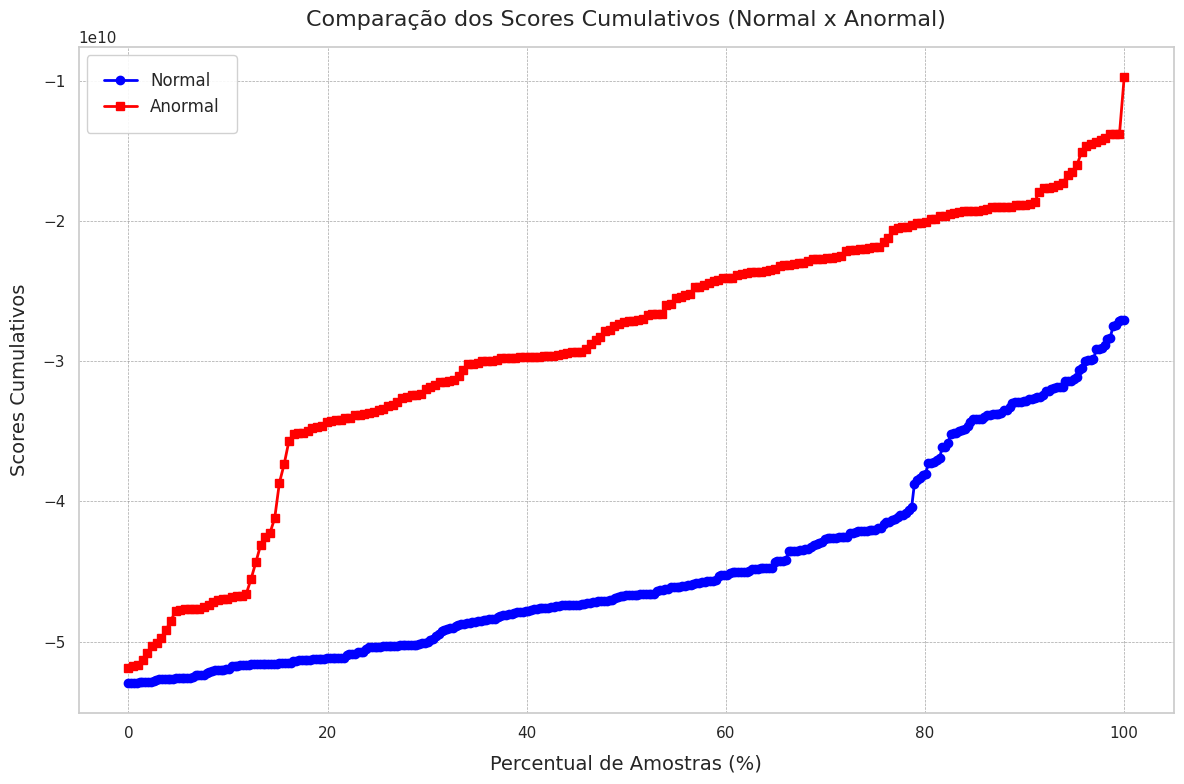

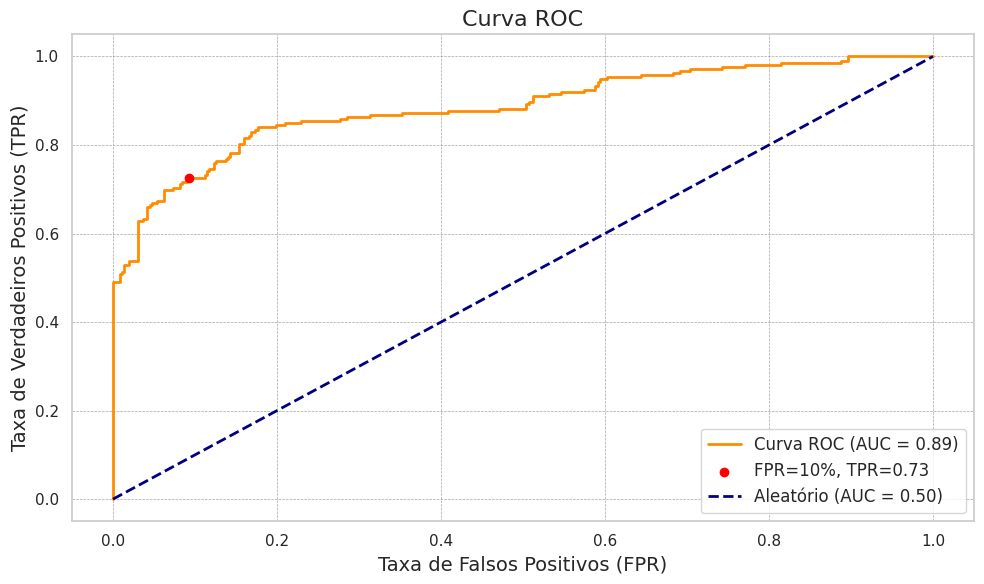

Taxa de detecção para FPR=10%: 72.64%
Tempo total de execução: 603.29 segundos


Iterações de treinamento:   0%|          | 0/15 [00:00<?, ?it/s]

primeiros valores de matriz_detetores: [[225  13  81  11 171 281 242  75  28  95 207   3 235  62 284 179  21 294
  154 107  77 104  24 252 151  59   4  78 209  16  89 300 253  52 159 290
  187 125 212  33  84 184   1 176  69  93  97 197 262 173 131  61 288  98
   96  67 198 273 122  35 279 134 161 259  34  92  57 231 106 174  88 162
   42 229 289  22  19 272 239  60 224 255  37 126   6 190 285  50 101 105
  169 168  85 240 256 111 117 127 238 251 112 270  87 260 164 191 257 216
  210 124  12 152   9 102 141  94  49 165 250 120 188 223  23 258 148  51
  206 237 243  46 185 114 109 195  30 121 274 178 145 219 276  10   5  71
  233 138  91 222  54  79 213 146 221 211  65   7 115 155  17   2  36 149
  156 287  47  64 248 192 263 177 297  14 202 182 143 268 261 234 160 214
    8 267 293 299 153 181 264 158 204  80 286 232 144  15 183 116 118 236
  163 166  31 269 220 157 180 283 201  55 167 199 203 295 128 230 228  29
  140 100 227 278  44  66 282 271  99 137 291 266 218 123 133 147 136 208


Iterações de treinamento:   7%|▋         | 1/15 [00:40<09:21, 40.13s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([  -3,   62,  252, -151,  -52,  212,  -84,  262, -173,  131,  161,
         92, -101, -111,  191,   12, -223,   23,  121,  274, -182, -143,
       -232, -283, -203,   44,   73, -245,  -32, -292]))]
primeiros valores de scores_normal_80: [[4.25516056e+08 5.18801579e+08 1.48415014e+08 6.25533430e+08
  3.20385730e+07 7.92555879e+08 4.96485134e+08 6.73142300e+06
  8.31962332e+08 5.24885253e+08 8.43313472e+08 1.45630067e+08
  5.35418612e+08 1.82233740e+08 3.63026517e+08 8.53248588e+08
  1.35766673e+08 5.65003273e+08 2.78376008e+08 5.41472112e+08
  8.94717740e+07 1.62998330e+08 6.44575551e+08 1.61672353e+08
  5.94268386e+08 8.04047225e+08 9.89074712e+08 2.06605514e+08
  6.23370214e+08 1.06537377e+09 1.03394649e+08 7.19741917e+08
  4.67231264e+08 7.47135900e+08 2.78359581e+08 6.62387896e+08
  7.15369368e+08 2.94463600e+08 5.17810445e+08 3.22367133e+08
  7.88857103e+08 1.05812897e+09 6.87850842e+08 8.49332554e+08
  1.15850010e+08 2.3195528


Iterações de treinamento:  13%|█▎        | 2/15 [01:20<08:40, 40.03s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 173,  212,  121,   52,  -32,  232,    3,  -12, -203, -292, -223,
        182,  161,   92, -111,  -62, -131, -283,  143, -101,   44, -151,
        274,   73, -245,  252,   84,   23, -191,  262]))]
primeiros valores de scores_normal_80: [[1.03226032e+09 7.88945111e+08 4.60434777e+08 1.02959375e+09
  8.61695137e+08 1.04865458e+09 1.07318353e+09 5.32779739e+08
  1.06883741e+09 4.36017313e+08 8.59707681e+08 1.06537377e+09
  4.63330566e+08 7.99561344e+08 1.00800998e+09 3.93757132e+08
  3.22413688e+08 7.85284031e+08 6.00771005e+08 1.05812897e+09
  6.67811737e+08 9.35443135e+08 7.69210469e+08 8.05235587e+08
  1.00335537e+09 1.06980381e+09 6.59867963e+08 3.83391793e+08
  7.88248652e+08 1.00577890e+09 5.20412315e+08 1.01645069e+09
  9.39173403e+08 1.07356861e+09 3.33791344e+08 1.91432812e+08
  3.85233576e+08 7.89843839e+08 8.03746192e+08 8.01089229e+08
  7.63635848e+08 3.64239196e+08 6.61038044e+08 4.66201950e+08
  2.40287464e+08 6.7322215


Iterações de treinamento:  20%|██        | 3/15 [01:59<07:59, 39.95s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  1.06400289e+09 1.06325627e+09 2.67474511e+08 1.06014017e+09
  5.37944620e+07 1.03389563e+09 8.61695137e+08 1.04865458e+09
  1.07318353e+09 5.32779739e+08 9.88164831e+08 1.05280050e+09
  4.89729985e+08 1.06537377e+09 8.59707681e+08 1.06883741e+09
  4.36017313e+08 1.01092538e+09 7.99561344e+08 8.48733056e+08
  7.93534395e+08 2.48123961e+08 4.63330566e+08 1.06108647e+09
  3.93757132e+08 1.01066593e+09 1.03349582e+09 1.00800998e+09
  6.00771005e+08 7.85284031e+08 3.22413688e+08 7.81981825e+08
  1.05812897e+09 1.05262237e+09 9.37219142e+08 4.23790297e+08
  1.02955090e+09 8.5468690


Iterações de treinamento:  27%|██▋       | 4/15 [02:40<07:21, 40.15s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 5.37944620e+07 1.03389563e+09
  1.06014017e+09 1.06014017e+09 5.37944620e+07 1.03389563e+09
  8.61695137e+08 5.32779739e+08 1.07318353e+09 1.04865458e+09
  9.88164831e+08 1.05280050e+09 9.88164831e+08 1.05280050e+09
  1.01092538e+09 4.36017313e+08 1.06883741e+09 8.59707681e+08
  1.06537377e+09 4.89729985e+08 1.01092538e+09 4.89729985e+08
  7.93534395e+08 2.48123961e+08 7.93534395e+08 1.06108647e+09
  1.06108647e+09 7.9956134


Iterações de treinamento:  33%|███▎      | 5/15 [03:21<06:44, 40.41s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 2.67474511e+08
  1.06325627e+09 1.06325627e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 1.06014017e+09 5.37944620e+07 1.06014017e+09
  1.03389563e+09 5.37944620e+07 1.03389563e+09 1.06014017e+09
  1.03389563e+09 5.37944620e+07 8.61695137e+08 5.32779739e+08
  1.07318353e+09 1.04865458e+09 9.88164831e+08 1.05280050e+09
  9.88164831e+08 1.05280050e+09 9.88164831e+08 1.05280050e+09
  4.36017313e+08 1.0109253


Iterações de treinamento:  40%|████      | 6/15 [04:02<06:05, 40.57s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  2.67474511e+08 1.06325627e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 2.67474511e+08 1.06325627e+09
  1.03389563e+09 5.37944620e+07 1.03389563e+09 5.37944620e+07
  1.03389563e+09 1.06014017e+09 1.06014017e+09 1.03389563e+09
  1.06014017e+09 5.37944620e+07 1.06014017e+09 5.37944620e+07
  8.61695137e+08 5.3277973


Iterações de treinamento:  47%|████▋     | 7/15 [04:42<05:23, 40.40s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06325627e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 1.06325627e+09 2.67474511e+08 1.03389563e+09
  5.37944620e+07 1.03389563e+09 5.37944620e+07 1.06014017e+09
  5.37944620e+07 1.0601401


Iterações de treinamento:  53%|█████▎    | 8/15 [05:23<04:45, 40.72s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 1.06325627e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.6747451


Iterações de treinamento:  60%|██████    | 9/15 [06:04<04:05, 40.85s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.6747451


Iterações de treinamento:  67%|██████▋   | 10/15 [06:45<03:23, 40.77s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06325627e+09 2.6747451


Iterações de treinamento:  73%|███████▎  | 11/15 [07:26<02:43, 40.79s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.0640028


Iterações de treinamento:  80%|████████  | 12/15 [08:07<02:02, 40.86s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.0640028


Iterações de treinamento:  87%|████████▋ | 13/15 [08:48<01:21, 40.88s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.8169310


Iterações de treinamento:  93%|█████████▎| 14/15 [09:29<00:40, 40.94s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.8169310


Iterações de treinamento: 100%|██████████| 15/15 [10:10<00:00, 40.69s/it]


primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.8169310

Calculando scores: 100%|██████████| 357/357 [00:00<00:00, 591.97it/s]


primeiros valores de scores_normal_100: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08]]
primeiros valores de sublists_anomalous: [(0, 0, array([ 162,  133, -279,  104,  192,  206,   -5, -112,   77,  -58, -154,
        -67,  227, -173, -266,   34, -183, -246,   25,  -87,

Calculando scores: 100%|██████████| 212/212 [00:00<00:00, 774.23it/s]


primeiros valores de scores_anomalous: [[9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 1.03787778e+09 3.93617022e+08
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  9.21595784e+08 7.46935867e+08 1.76347690e+08 1.76347690e+08
  1.76347690e+08 1.76347690e+08]]
primeiros valores de negative_scores_normal: [[-1.03302862e+09 -1.03302862e+09 -1.03302862e+09 -1.03302862e+09
  -1.03302862e+09 -1.03302862e+09 -1.03302862e+09 -1.03302862e+09
  -1.0

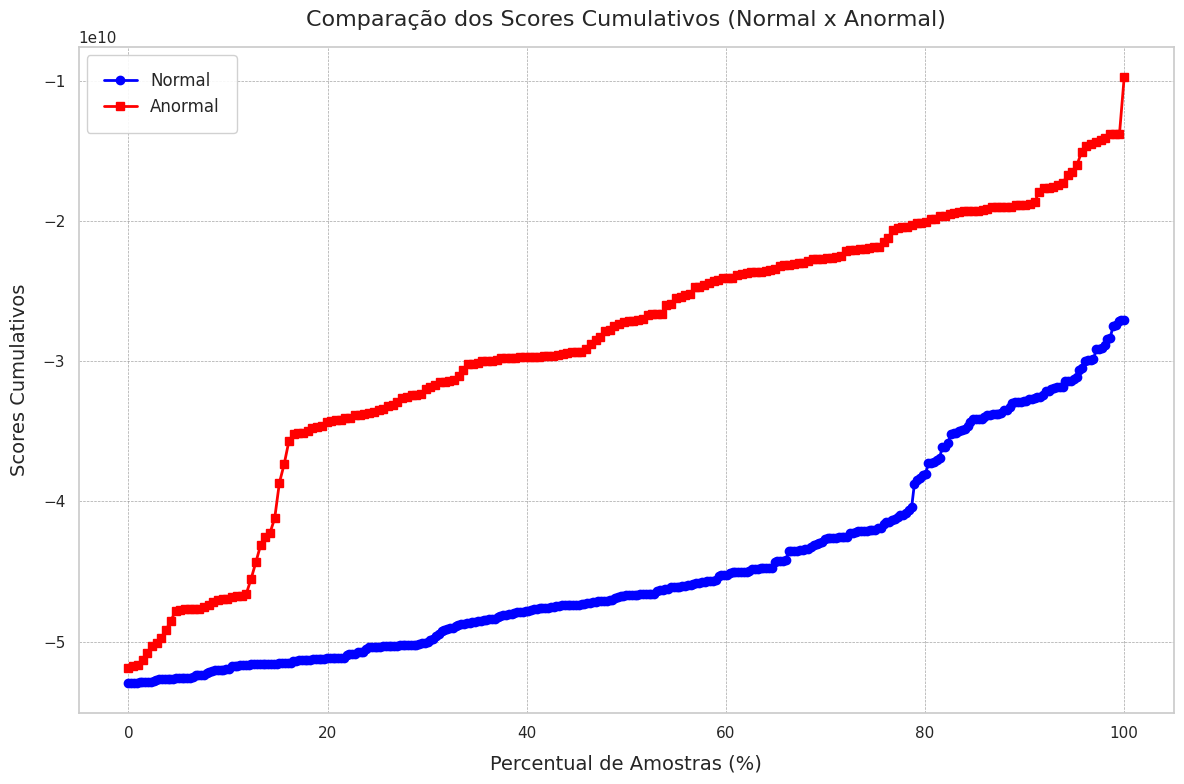

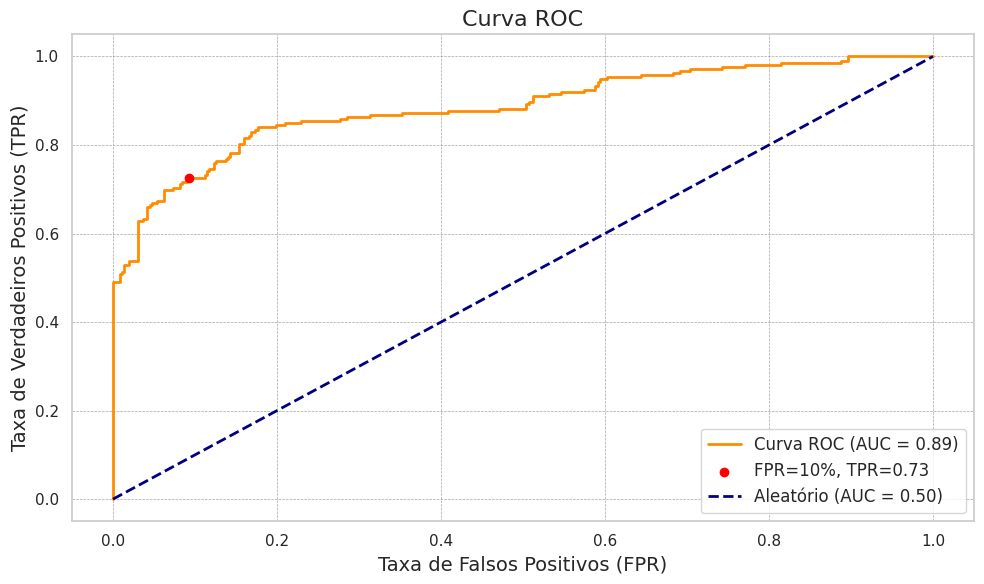

Taxa de detecção para FPR=10%: 72.64%
Tempo total de execução: 617.85 segundos


Iterações de treinamento:   0%|          | 0/15 [00:00<?, ?it/s]

primeiros valores de matriz_detetores: [[225  13  81  11 171 281 242  75  28  95 207   3 235  62 284 179  21 294
  154 107  77 104  24 252 151  59   4  78 209  16  89 300 253  52 159 290
  187 125 212  33  84 184   1 176  69  93  97 197 262 173 131  61 288  98
   96  67 198 273 122  35 279 134 161 259  34  92  57 231 106 174  88 162
   42 229 289  22  19 272 239  60 224 255  37 126   6 190 285  50 101 105
  169 168  85 240 256 111 117 127 238 251 112 270  87 260 164 191 257 216
  210 124  12 152   9 102 141  94  49 165 250 120 188 223  23 258 148  51
  206 237 243  46 185 114 109 195  30 121 274 178 145 219 276  10   5  71
  233 138  91 222  54  79 213 146 221 211  65   7 115 155  17   2  36 149
  156 287  47  64 248 192 263 177 297  14 202 182 143 268 261 234 160 214
    8 267 293 299 153 181 264 158 204  80 286 232 144  15 183 116 118 236
  163 166  31 269 220 157 180 283 201  55 167 199 203 295 128 230 228  29
  140 100 227 278  44  66 282 271  99 137 291 266 218 123 133 147 136 208


Iterações de treinamento:   7%|▋         | 1/15 [00:41<09:34, 41.01s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([  -3,   62,  252, -151,  -52,  212,  -84,  262, -173,  131,  161,
         92, -101, -111,  191,   12, -223,   23,  121,  274, -182, -143,
       -232, -283, -203,   44,   73, -245,  -32, -292]))]
primeiros valores de scores_normal_80: [[4.25516056e+08 5.18801579e+08 1.48415014e+08 6.25533430e+08
  3.20385730e+07 7.92555879e+08 4.96485134e+08 6.73142300e+06
  8.31962332e+08 5.24885253e+08 8.43313472e+08 1.45630067e+08
  5.35418612e+08 1.82233740e+08 3.63026517e+08 8.53248588e+08
  1.35766673e+08 5.65003273e+08 2.78376008e+08 5.41472112e+08
  8.94717740e+07 1.62998330e+08 6.44575551e+08 1.61672353e+08
  5.94268386e+08 8.04047225e+08 9.89074712e+08 2.06605514e+08
  6.23370214e+08 1.06537377e+09 1.03394649e+08 7.19741917e+08
  4.67231264e+08 7.47135900e+08 2.78359581e+08 6.62387896e+08
  7.15369368e+08 2.94463600e+08 5.17810445e+08 3.22367133e+08
  7.88857103e+08 1.05812897e+09 6.87850842e+08 8.49332554e+08
  1.15850010e+08 2.3195528


Iterações de treinamento:  13%|█▎        | 2/15 [01:22<08:56, 41.28s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 173,  212,  121,   52,  -32,  232,    3,  -12, -203, -292, -223,
        182,  161,   92, -111,  -62, -131, -283,  143, -101,   44, -151,
        274,   73, -245,  252,   84,   23, -191,  262]))]
primeiros valores de scores_normal_80: [[1.03226032e+09 7.88945111e+08 4.60434777e+08 1.02959375e+09
  8.61695137e+08 1.04865458e+09 1.07318353e+09 5.32779739e+08
  1.06883741e+09 4.36017313e+08 8.59707681e+08 1.06537377e+09
  4.63330566e+08 7.99561344e+08 1.00800998e+09 3.93757132e+08
  3.22413688e+08 7.85284031e+08 6.00771005e+08 1.05812897e+09
  6.67811737e+08 9.35443135e+08 7.69210469e+08 8.05235587e+08
  1.00335537e+09 1.06980381e+09 6.59867963e+08 3.83391793e+08
  7.88248652e+08 1.00577890e+09 5.20412315e+08 1.01645069e+09
  9.39173403e+08 1.07356861e+09 3.33791344e+08 1.91432812e+08
  3.85233576e+08 7.89843839e+08 8.03746192e+08 8.01089229e+08
  7.63635848e+08 3.64239196e+08 6.61038044e+08 4.66201950e+08
  2.40287464e+08 6.7322215


Iterações de treinamento:  20%|██        | 3/15 [02:03<08:14, 41.23s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  1.06400289e+09 1.06325627e+09 2.67474511e+08 1.06014017e+09
  5.37944620e+07 1.03389563e+09 8.61695137e+08 1.04865458e+09
  1.07318353e+09 5.32779739e+08 9.88164831e+08 1.05280050e+09
  4.89729985e+08 1.06537377e+09 8.59707681e+08 1.06883741e+09
  4.36017313e+08 1.01092538e+09 7.99561344e+08 8.48733056e+08
  7.93534395e+08 2.48123961e+08 4.63330566e+08 1.06108647e+09
  3.93757132e+08 1.01066593e+09 1.03349582e+09 1.00800998e+09
  6.00771005e+08 7.85284031e+08 3.22413688e+08 7.81981825e+08
  1.05812897e+09 1.05262237e+09 9.37219142e+08 4.23790297e+08
  1.02955090e+09 8.5468690


Iterações de treinamento:  27%|██▋       | 4/15 [02:44<07:32, 41.16s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 5.37944620e+07 1.03389563e+09
  1.06014017e+09 1.06014017e+09 5.37944620e+07 1.03389563e+09
  8.61695137e+08 5.32779739e+08 1.07318353e+09 1.04865458e+09
  9.88164831e+08 1.05280050e+09 9.88164831e+08 1.05280050e+09
  1.01092538e+09 4.36017313e+08 1.06883741e+09 8.59707681e+08
  1.06537377e+09 4.89729985e+08 1.01092538e+09 4.89729985e+08
  7.93534395e+08 2.48123961e+08 7.93534395e+08 1.06108647e+09
  1.06108647e+09 7.9956134


Iterações de treinamento:  33%|███▎      | 5/15 [03:25<06:51, 41.19s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 2.67474511e+08
  1.06325627e+09 1.06325627e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 1.06014017e+09 5.37944620e+07 1.06014017e+09
  1.03389563e+09 5.37944620e+07 1.03389563e+09 1.06014017e+09
  1.03389563e+09 5.37944620e+07 8.61695137e+08 5.32779739e+08
  1.07318353e+09 1.04865458e+09 9.88164831e+08 1.05280050e+09
  9.88164831e+08 1.05280050e+09 9.88164831e+08 1.05280050e+09
  4.36017313e+08 1.0109253


Iterações de treinamento:  40%|████      | 6/15 [04:07<06:12, 41.36s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  2.67474511e+08 1.06325627e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 2.67474511e+08 1.06325627e+09
  1.03389563e+09 5.37944620e+07 1.03389563e+09 5.37944620e+07
  1.03389563e+09 1.06014017e+09 1.06014017e+09 1.03389563e+09
  1.06014017e+09 5.37944620e+07 1.06014017e+09 5.37944620e+07
  8.61695137e+08 5.3277973


Iterações de treinamento:  47%|████▋     | 7/15 [04:49<05:31, 41.49s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06325627e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 1.06325627e+09 2.67474511e+08 1.03389563e+09
  5.37944620e+07 1.03389563e+09 5.37944620e+07 1.06014017e+09
  5.37944620e+07 1.0601401


Iterações de treinamento:  53%|█████▎    | 8/15 [05:31<04:51, 41.59s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 1.06325627e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.6747451


Iterações de treinamento:  60%|██████    | 9/15 [06:14<04:12, 42.06s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.6747451


Iterações de treinamento:  67%|██████▋   | 10/15 [06:55<03:29, 41.94s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06325627e+09 2.6747451


Iterações de treinamento:  73%|███████▎  | 11/15 [07:37<02:47, 41.78s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.0640028


Iterações de treinamento:  80%|████████  | 12/15 [08:19<02:05, 41.83s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.0640028


Iterações de treinamento:  87%|████████▋ | 13/15 [09:01<01:23, 41.90s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.8169310


Iterações de treinamento:  93%|█████████▎| 14/15 [09:43<00:41, 41.94s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.8169310


Iterações de treinamento: 100%|██████████| 15/15 [10:24<00:00, 41.66s/it]


primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.8169310

Calculando scores: 100%|██████████| 357/357 [00:00<00:00, 727.05it/s]


primeiros valores de scores_normal_100: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08]]
primeiros valores de sublists_anomalous: [(0, 0, array([ 162,  133, -279,  104,  192,  206,   -5, -112,   77,  -58, -154,
        -67,  227, -173, -266,   34, -183, -246,   25,  -87,

Calculando scores: 100%|██████████| 212/212 [00:00<00:00, 763.27it/s]


primeiros valores de scores_anomalous: [[9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 1.03787778e+09 3.93617022e+08
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  9.21595784e+08 7.46935867e+08 1.76347690e+08 1.76347690e+08
  1.76347690e+08 1.76347690e+08]]
primeiros valores de negative_scores_normal: [[-1.03302862e+09 -1.03302862e+09 -1.03302862e+09 -1.03302862e+09
  -1.03302862e+09 -1.03302862e+09 -1.03302862e+09 -1.03302862e+09
  -1.0

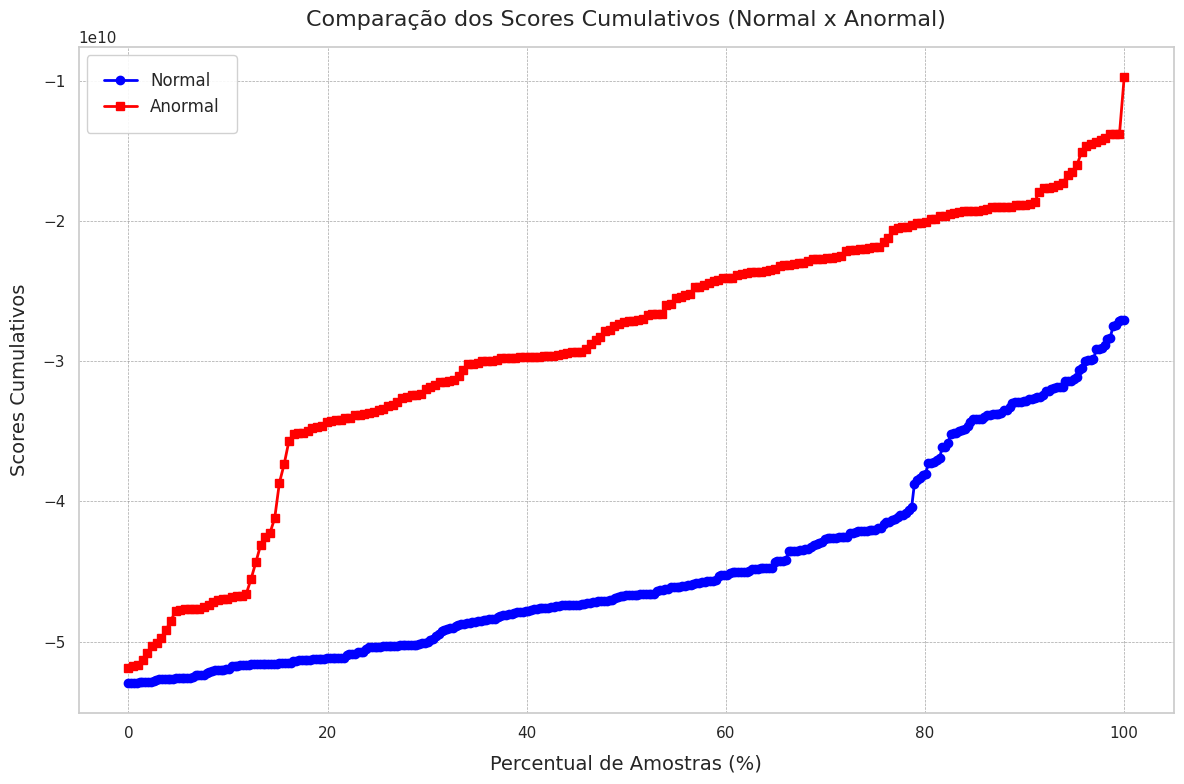

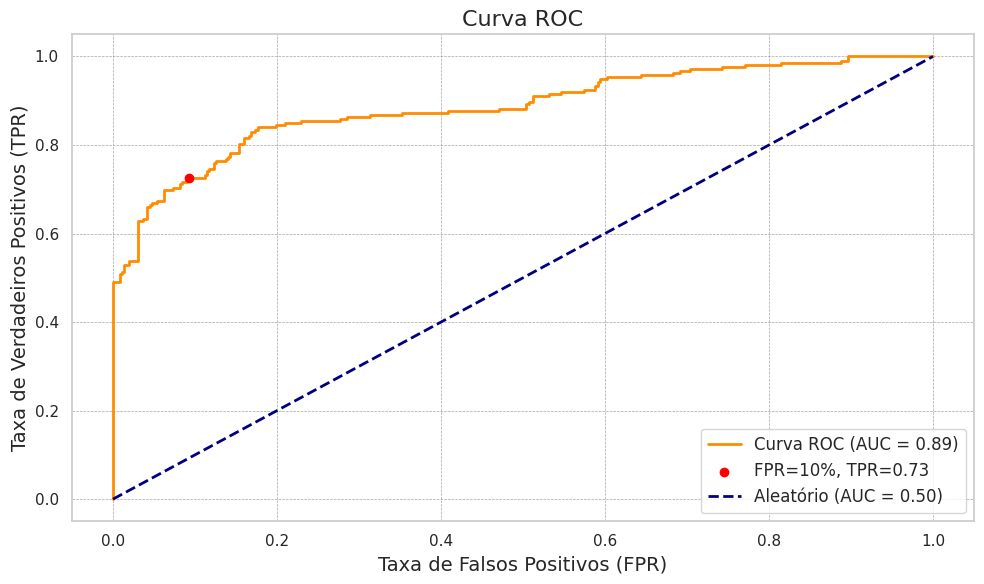

Taxa de detecção para FPR=10%: 72.64%
Tempo total de execução: 632.69 segundos


Iterações de treinamento:   0%|          | 0/15 [00:00<?, ?it/s]

primeiros valores de matriz_detetores: [[225  13  81  11 171 281 242  75  28  95 207   3 235  62 284 179  21 294
  154 107  77 104  24 252 151  59   4  78 209  16  89 300 253  52 159 290
  187 125 212  33  84 184   1 176  69  93  97 197 262 173 131  61 288  98
   96  67 198 273 122  35 279 134 161 259  34  92  57 231 106 174  88 162
   42 229 289  22  19 272 239  60 224 255  37 126   6 190 285  50 101 105
  169 168  85 240 256 111 117 127 238 251 112 270  87 260 164 191 257 216
  210 124  12 152   9 102 141  94  49 165 250 120 188 223  23 258 148  51
  206 237 243  46 185 114 109 195  30 121 274 178 145 219 276  10   5  71
  233 138  91 222  54  79 213 146 221 211  65   7 115 155  17   2  36 149
  156 287  47  64 248 192 263 177 297  14 202 182 143 268 261 234 160 214
    8 267 293 299 153 181 264 158 204  80 286 232 144  15 183 116 118 236
  163 166  31 269 220 157 180 283 201  55 167 199 203 295 128 230 228  29
  140 100 227 278  44  66 282 271  99 137 291 266 218 123 133 147 136 208


Iterações de treinamento:   7%|▋         | 1/15 [00:40<09:29, 40.69s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([  -3,   62,  252, -151,  -52,  212,  -84,  262, -173,  131,  161,
         92, -101, -111,  191,   12, -223,   23,  121,  274, -182, -143,
       -232, -283, -203,   44,   73, -245,  -32, -292]))]
primeiros valores de scores_normal_80: [[4.25516056e+08 5.18801579e+08 1.48415014e+08 6.25533430e+08
  3.20385730e+07 7.92555879e+08 4.96485134e+08 6.73142300e+06
  8.31962332e+08 5.24885253e+08 8.43313472e+08 1.45630067e+08
  5.35418612e+08 1.82233740e+08 3.63026517e+08 8.53248588e+08
  1.35766673e+08 5.65003273e+08 2.78376008e+08 5.41472112e+08
  8.94717740e+07 1.62998330e+08 6.44575551e+08 1.61672353e+08
  5.94268386e+08 8.04047225e+08 9.89074712e+08 2.06605514e+08
  6.23370214e+08 1.06537377e+09 1.03394649e+08 7.19741917e+08
  4.67231264e+08 7.47135900e+08 2.78359581e+08 6.62387896e+08
  7.15369368e+08 2.94463600e+08 5.17810445e+08 3.22367133e+08
  7.88857103e+08 1.05812897e+09 6.87850842e+08 8.49332554e+08
  1.15850010e+08 2.3195528


Iterações de treinamento:  13%|█▎        | 2/15 [01:23<09:05, 41.93s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 173,  212,  121,   52,  -32,  232,    3,  -12, -203, -292, -223,
        182,  161,   92, -111,  -62, -131, -283,  143, -101,   44, -151,
        274,   73, -245,  252,   84,   23, -191,  262]))]
primeiros valores de scores_normal_80: [[1.03226032e+09 7.88945111e+08 4.60434777e+08 1.02959375e+09
  8.61695137e+08 1.04865458e+09 1.07318353e+09 5.32779739e+08
  1.06883741e+09 4.36017313e+08 8.59707681e+08 1.06537377e+09
  4.63330566e+08 7.99561344e+08 1.00800998e+09 3.93757132e+08
  3.22413688e+08 7.85284031e+08 6.00771005e+08 1.05812897e+09
  6.67811737e+08 9.35443135e+08 7.69210469e+08 8.05235587e+08
  1.00335537e+09 1.06980381e+09 6.59867963e+08 3.83391793e+08
  7.88248652e+08 1.00577890e+09 5.20412315e+08 1.01645069e+09
  9.39173403e+08 1.07356861e+09 3.33791344e+08 1.91432812e+08
  3.85233576e+08 7.89843839e+08 8.03746192e+08 8.01089229e+08
  7.63635848e+08 3.64239196e+08 6.61038044e+08 4.66201950e+08
  2.40287464e+08 6.7322215


Iterações de treinamento:  20%|██        | 3/15 [02:06<08:27, 42.31s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  1.06400289e+09 1.06325627e+09 2.67474511e+08 1.06014017e+09
  5.37944620e+07 1.03389563e+09 8.61695137e+08 1.04865458e+09
  1.07318353e+09 5.32779739e+08 9.88164831e+08 1.05280050e+09
  4.89729985e+08 1.06537377e+09 8.59707681e+08 1.06883741e+09
  4.36017313e+08 1.01092538e+09 7.99561344e+08 8.48733056e+08
  7.93534395e+08 2.48123961e+08 4.63330566e+08 1.06108647e+09
  3.93757132e+08 1.01066593e+09 1.03349582e+09 1.00800998e+09
  6.00771005e+08 7.85284031e+08 3.22413688e+08 7.81981825e+08
  1.05812897e+09 1.05262237e+09 9.37219142e+08 4.23790297e+08
  1.02955090e+09 8.5468690


Iterações de treinamento:  27%|██▋       | 4/15 [02:48<07:45, 42.32s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 5.37944620e+07 1.03389563e+09
  1.06014017e+09 1.06014017e+09 5.37944620e+07 1.03389563e+09
  8.61695137e+08 5.32779739e+08 1.07318353e+09 1.04865458e+09
  9.88164831e+08 1.05280050e+09 9.88164831e+08 1.05280050e+09
  1.01092538e+09 4.36017313e+08 1.06883741e+09 8.59707681e+08
  1.06537377e+09 4.89729985e+08 1.01092538e+09 4.89729985e+08
  7.93534395e+08 2.48123961e+08 7.93534395e+08 1.06108647e+09
  1.06108647e+09 7.9956134


Iterações de treinamento:  33%|███▎      | 5/15 [03:31<07:04, 42.41s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 2.67474511e+08
  1.06325627e+09 1.06325627e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 1.06014017e+09 5.37944620e+07 1.06014017e+09
  1.03389563e+09 5.37944620e+07 1.03389563e+09 1.06014017e+09
  1.03389563e+09 5.37944620e+07 8.61695137e+08 5.32779739e+08
  1.07318353e+09 1.04865458e+09 9.88164831e+08 1.05280050e+09
  9.88164831e+08 1.05280050e+09 9.88164831e+08 1.05280050e+09
  4.36017313e+08 1.0109253


Iterações de treinamento:  40%|████      | 6/15 [04:13<06:21, 42.41s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  2.67474511e+08 1.06325627e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 2.67474511e+08 1.06325627e+09
  1.03389563e+09 5.37944620e+07 1.03389563e+09 5.37944620e+07
  1.03389563e+09 1.06014017e+09 1.06014017e+09 1.03389563e+09
  1.06014017e+09 5.37944620e+07 1.06014017e+09 5.37944620e+07
  8.61695137e+08 5.3277973


Iterações de treinamento:  47%|████▋     | 7/15 [04:56<05:41, 42.64s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06325627e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 1.06325627e+09 2.67474511e+08 1.03389563e+09
  5.37944620e+07 1.03389563e+09 5.37944620e+07 1.06014017e+09
  5.37944620e+07 1.0601401


Iterações de treinamento:  53%|█████▎    | 8/15 [05:39<04:59, 42.77s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 1.06325627e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.6747451


Iterações de treinamento:  60%|██████    | 9/15 [06:24<04:20, 43.45s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.6747451


Iterações de treinamento:  67%|██████▋   | 10/15 [07:08<03:37, 43.55s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06325627e+09 2.6747451


Iterações de treinamento:  73%|███████▎  | 11/15 [07:51<02:53, 43.41s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.0640028


Iterações de treinamento:  80%|████████  | 12/15 [08:34<02:09, 43.28s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.0640028


Iterações de treinamento:  87%|████████▋ | 13/15 [09:18<01:27, 43.51s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.8169310


Iterações de treinamento:  93%|█████████▎| 14/15 [10:02<00:43, 43.50s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.8169310


Iterações de treinamento: 100%|██████████| 15/15 [10:46<00:00, 43.08s/it]


primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.8169310

Calculando scores: 100%|██████████| 357/357 [00:00<00:00, 743.76it/s]


primeiros valores de scores_normal_100: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08]]
primeiros valores de sublists_anomalous: [(0, 0, array([ 162,  133, -279,  104,  192,  206,   -5, -112,   77,  -58, -154,
        -67,  227, -173, -266,   34, -183, -246,   25,  -87,

Calculando scores: 100%|██████████| 212/212 [00:00<00:00, 752.95it/s]


primeiros valores de scores_anomalous: [[9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 1.03787778e+09 3.93617022e+08
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  9.21595784e+08 7.46935867e+08 1.76347690e+08 1.76347690e+08
  1.76347690e+08 1.76347690e+08]]
primeiros valores de negative_scores_normal: [[-1.03302862e+09 -1.03302862e+09 -1.03302862e+09 -1.03302862e+09
  -1.03302862e+09 -1.03302862e+09 -1.03302862e+09 -1.03302862e+09
  -1.0

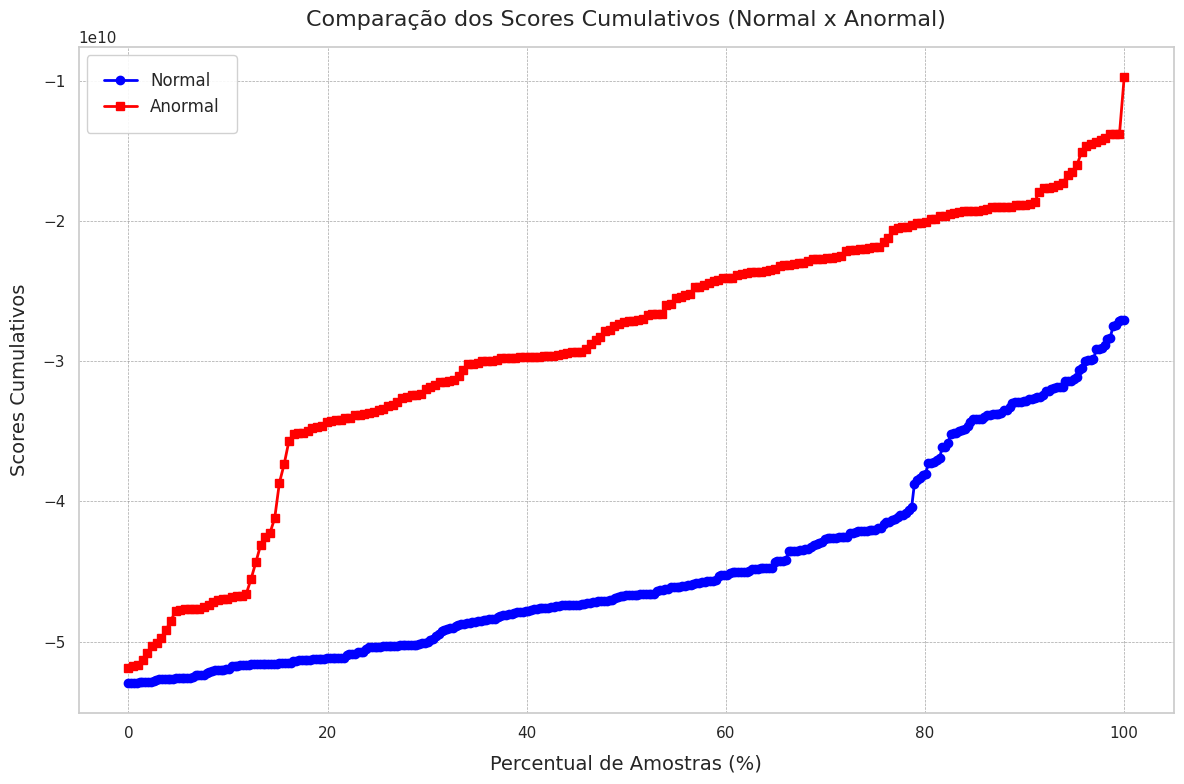

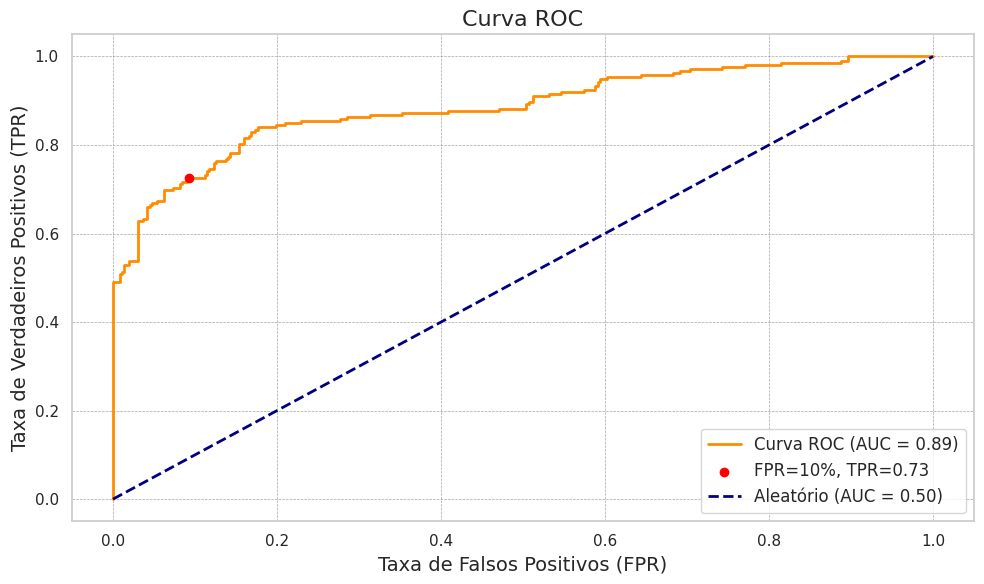

Taxa de detecção para FPR=10%: 72.64%
Tempo total de execução: 654.14 segundos


Iterações de treinamento:   0%|          | 0/15 [00:00<?, ?it/s]

primeiros valores de matriz_detetores: [[225  13  81  11 171 281 242  75  28  95 207   3 235  62 284 179  21 294
  154 107  77 104  24 252 151  59   4  78 209  16  89 300 253  52 159 290
  187 125 212  33  84 184   1 176  69  93  97 197 262 173 131  61 288  98
   96  67 198 273 122  35 279 134 161 259  34  92  57 231 106 174  88 162
   42 229 289  22  19 272 239  60 224 255  37 126   6 190 285  50 101 105
  169 168  85 240 256 111 117 127 238 251 112 270  87 260 164 191 257 216
  210 124  12 152   9 102 141  94  49 165 250 120 188 223  23 258 148  51
  206 237 243  46 185 114 109 195  30 121 274 178 145 219 276  10   5  71
  233 138  91 222  54  79 213 146 221 211  65   7 115 155  17   2  36 149
  156 287  47  64 248 192 263 177 297  14 202 182 143 268 261 234 160 214
    8 267 293 299 153 181 264 158 204  80 286 232 144  15 183 116 118 236
  163 166  31 269 220 157 180 283 201  55 167 199 203 295 128 230 228  29
  140 100 227 278  44  66 282 271  99 137 291 266 218 123 133 147 136 208


Iterações de treinamento:   7%|▋         | 1/15 [00:42<10:01, 42.95s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([  -3,   62,  252, -151,  -52,  212,  -84,  262, -173,  131,  161,
         92, -101, -111,  191,   12, -223,   23,  121,  274, -182, -143,
       -232, -283, -203,   44,   73, -245,  -32, -292]))]
primeiros valores de scores_normal_80: [[4.25516056e+08 5.18801579e+08 1.48415014e+08 6.25533430e+08
  3.20385730e+07 7.92555879e+08 4.96485134e+08 6.73142300e+06
  8.31962332e+08 5.24885253e+08 8.43313472e+08 1.45630067e+08
  5.35418612e+08 1.82233740e+08 3.63026517e+08 8.53248588e+08
  1.35766673e+08 5.65003273e+08 2.78376008e+08 5.41472112e+08
  8.94717740e+07 1.62998330e+08 6.44575551e+08 1.61672353e+08
  5.94268386e+08 8.04047225e+08 9.89074712e+08 2.06605514e+08
  6.23370214e+08 1.06537377e+09 1.03394649e+08 7.19741917e+08
  4.67231264e+08 7.47135900e+08 2.78359581e+08 6.62387896e+08
  7.15369368e+08 2.94463600e+08 5.17810445e+08 3.22367133e+08
  7.88857103e+08 1.05812897e+09 6.87850842e+08 8.49332554e+08
  1.15850010e+08 2.3195528


Iterações de treinamento:  13%|█▎        | 2/15 [01:26<09:22, 43.26s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 173,  212,  121,   52,  -32,  232,    3,  -12, -203, -292, -223,
        182,  161,   92, -111,  -62, -131, -283,  143, -101,   44, -151,
        274,   73, -245,  252,   84,   23, -191,  262]))]
primeiros valores de scores_normal_80: [[1.03226032e+09 7.88945111e+08 4.60434777e+08 1.02959375e+09
  8.61695137e+08 1.04865458e+09 1.07318353e+09 5.32779739e+08
  1.06883741e+09 4.36017313e+08 8.59707681e+08 1.06537377e+09
  4.63330566e+08 7.99561344e+08 1.00800998e+09 3.93757132e+08
  3.22413688e+08 7.85284031e+08 6.00771005e+08 1.05812897e+09
  6.67811737e+08 9.35443135e+08 7.69210469e+08 8.05235587e+08
  1.00335537e+09 1.06980381e+09 6.59867963e+08 3.83391793e+08
  7.88248652e+08 1.00577890e+09 5.20412315e+08 1.01645069e+09
  9.39173403e+08 1.07356861e+09 3.33791344e+08 1.91432812e+08
  3.85233576e+08 7.89843839e+08 8.03746192e+08 8.01089229e+08
  7.63635848e+08 3.64239196e+08 6.61038044e+08 4.66201950e+08
  2.40287464e+08 6.7322215


Iterações de treinamento:  20%|██        | 3/15 [02:10<08:41, 43.43s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  1.06400289e+09 1.06325627e+09 2.67474511e+08 1.06014017e+09
  5.37944620e+07 1.03389563e+09 8.61695137e+08 1.04865458e+09
  1.07318353e+09 5.32779739e+08 9.88164831e+08 1.05280050e+09
  4.89729985e+08 1.06537377e+09 8.59707681e+08 1.06883741e+09
  4.36017313e+08 1.01092538e+09 7.99561344e+08 8.48733056e+08
  7.93534395e+08 2.48123961e+08 4.63330566e+08 1.06108647e+09
  3.93757132e+08 1.01066593e+09 1.03349582e+09 1.00800998e+09
  6.00771005e+08 7.85284031e+08 3.22413688e+08 7.81981825e+08
  1.05812897e+09 1.05262237e+09 9.37219142e+08 4.23790297e+08
  1.02955090e+09 8.5468690


Iterações de treinamento:  27%|██▋       | 4/15 [02:53<07:58, 43.54s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 5.37944620e+07 1.03389563e+09
  1.06014017e+09 1.06014017e+09 5.37944620e+07 1.03389563e+09
  8.61695137e+08 5.32779739e+08 1.07318353e+09 1.04865458e+09
  9.88164831e+08 1.05280050e+09 9.88164831e+08 1.05280050e+09
  1.01092538e+09 4.36017313e+08 1.06883741e+09 8.59707681e+08
  1.06537377e+09 4.89729985e+08 1.01092538e+09 4.89729985e+08
  7.93534395e+08 2.48123961e+08 7.93534395e+08 1.06108647e+09
  1.06108647e+09 7.9956134


Iterações de treinamento:  33%|███▎      | 5/15 [03:37<07:15, 43.58s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 2.67474511e+08
  1.06325627e+09 1.06325627e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 1.06014017e+09 5.37944620e+07 1.06014017e+09
  1.03389563e+09 5.37944620e+07 1.03389563e+09 1.06014017e+09
  1.03389563e+09 5.37944620e+07 8.61695137e+08 5.32779739e+08
  1.07318353e+09 1.04865458e+09 9.88164831e+08 1.05280050e+09
  9.88164831e+08 1.05280050e+09 9.88164831e+08 1.05280050e+09
  4.36017313e+08 1.0109253


Iterações de treinamento:  40%|████      | 6/15 [04:21<06:33, 43.70s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  2.67474511e+08 1.06325627e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 2.67474511e+08 1.06325627e+09
  1.03389563e+09 5.37944620e+07 1.03389563e+09 5.37944620e+07
  1.03389563e+09 1.06014017e+09 1.06014017e+09 1.03389563e+09
  1.06014017e+09 5.37944620e+07 1.06014017e+09 5.37944620e+07
  8.61695137e+08 5.3277973


Iterações de treinamento:  47%|████▋     | 7/15 [05:05<05:50, 43.77s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06325627e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 1.06325627e+09 2.67474511e+08 1.03389563e+09
  5.37944620e+07 1.03389563e+09 5.37944620e+07 1.06014017e+09
  5.37944620e+07 1.0601401


Iterações de treinamento:  53%|█████▎    | 8/15 [05:50<05:08, 44.11s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 1.06325627e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.6747451


Iterações de treinamento:  60%|██████    | 9/15 [06:34<04:24, 44.12s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.6747451


Iterações de treinamento:  67%|██████▋   | 10/15 [07:18<03:40, 44.14s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06325627e+09 2.6747451


Iterações de treinamento:  73%|███████▎  | 11/15 [08:02<02:56, 44.10s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.0640028


Iterações de treinamento:  80%|████████  | 12/15 [08:46<02:12, 44.08s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.0640028


Iterações de treinamento:  87%|████████▋ | 13/15 [09:30<01:27, 43.96s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.8169310


Iterações de treinamento:  93%|█████████▎| 14/15 [10:14<00:44, 44.16s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.8169310


Iterações de treinamento: 100%|██████████| 15/15 [11:00<00:00, 44.04s/it]


primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.8169310

Calculando scores: 100%|██████████| 357/357 [00:00<00:00, 655.92it/s]


primeiros valores de scores_normal_100: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08]]
primeiros valores de sublists_anomalous: [(0, 0, array([ 162,  133, -279,  104,  192,  206,   -5, -112,   77,  -58, -154,
        -67,  227, -173, -266,   34, -183, -246,   25,  -87,

Calculando scores: 100%|██████████| 212/212 [00:00<00:00, 643.39it/s]


primeiros valores de scores_anomalous: [[9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 1.03787778e+09 3.93617022e+08
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  9.21595784e+08 7.46935867e+08 1.76347690e+08 1.76347690e+08
  1.76347690e+08 1.76347690e+08]]
primeiros valores de negative_scores_normal: [[-1.03302862e+09 -1.03302862e+09 -1.03302862e+09 -1.03302862e+09
  -1.03302862e+09 -1.03302862e+09 -1.03302862e+09 -1.03302862e+09
  -1.0

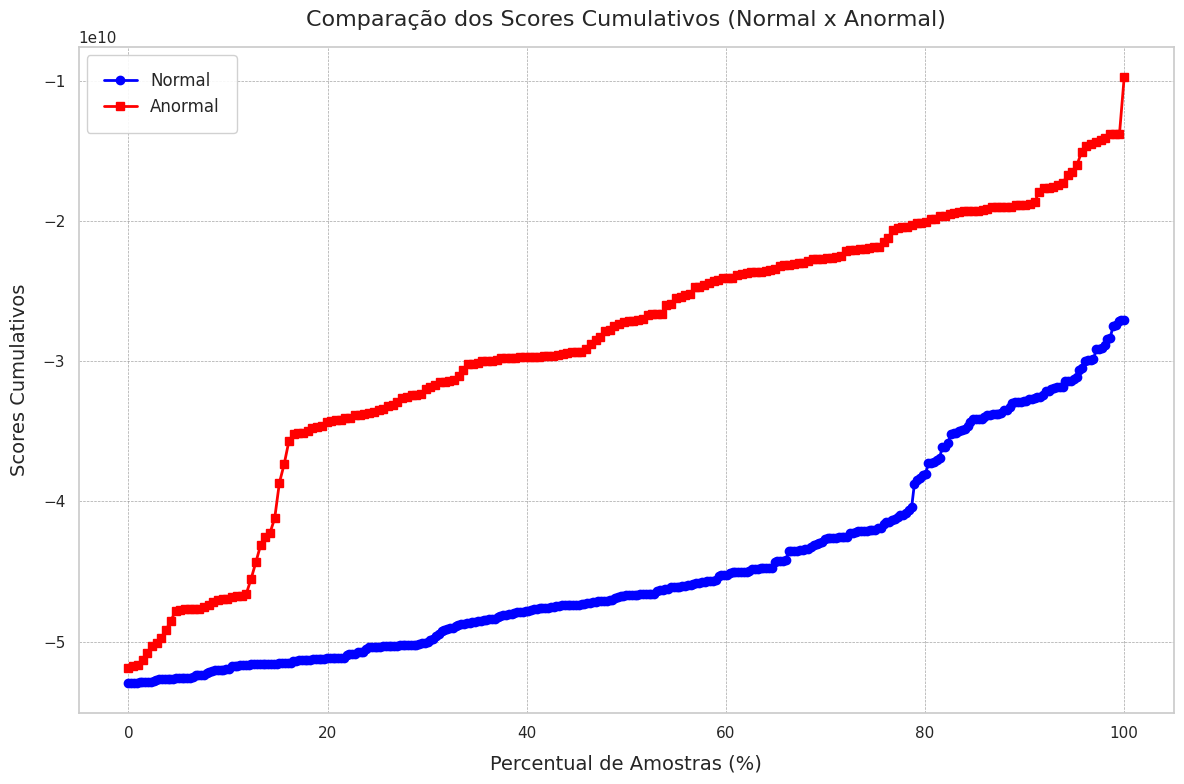

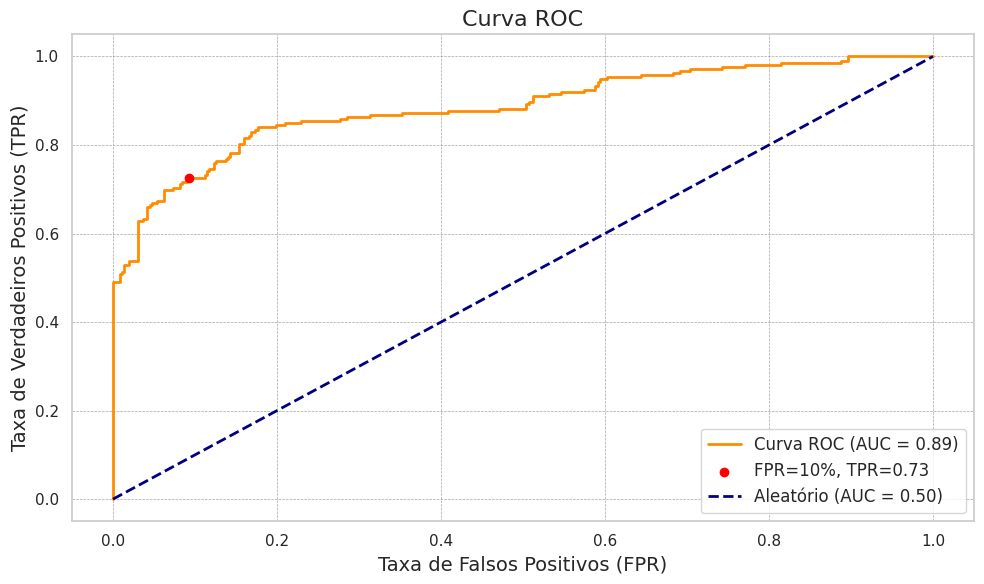

Taxa de detecção para FPR=10%: 72.64%
Tempo total de execução: 668.72 segundos


Iterações de treinamento:   0%|          | 0/15 [00:00<?, ?it/s]

primeiros valores de matriz_detetores: [[225  13  81  11 171 281 242  75  28  95 207   3 235  62 284 179  21 294
  154 107  77 104  24 252 151  59   4  78 209  16  89 300 253  52 159 290
  187 125 212  33  84 184   1 176  69  93  97 197 262 173 131  61 288  98
   96  67 198 273 122  35 279 134 161 259  34  92  57 231 106 174  88 162
   42 229 289  22  19 272 239  60 224 255  37 126   6 190 285  50 101 105
  169 168  85 240 256 111 117 127 238 251 112 270  87 260 164 191 257 216
  210 124  12 152   9 102 141  94  49 165 250 120 188 223  23 258 148  51
  206 237 243  46 185 114 109 195  30 121 274 178 145 219 276  10   5  71
  233 138  91 222  54  79 213 146 221 211  65   7 115 155  17   2  36 149
  156 287  47  64 248 192 263 177 297  14 202 182 143 268 261 234 160 214
    8 267 293 299 153 181 264 158 204  80 286 232 144  15 183 116 118 236
  163 166  31 269 220 157 180 283 201  55 167 199 203 295 128 230 228  29
  140 100 227 278  44  66 282 271  99 137 291 266 218 123 133 147 136 208


Iterações de treinamento:   7%|▋         | 1/15 [00:42<09:52, 42.36s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([  -3,   62,  252, -151,  -52,  212,  -84,  262, -173,  131,  161,
         92, -101, -111,  191,   12, -223,   23,  121,  274, -182, -143,
       -232, -283, -203,   44,   73, -245,  -32, -292]))]
primeiros valores de scores_normal_80: [[4.25516056e+08 5.18801579e+08 1.48415014e+08 6.25533430e+08
  3.20385730e+07 7.92555879e+08 4.96485134e+08 6.73142300e+06
  8.31962332e+08 5.24885253e+08 8.43313472e+08 1.45630067e+08
  5.35418612e+08 1.82233740e+08 3.63026517e+08 8.53248588e+08
  1.35766673e+08 5.65003273e+08 2.78376008e+08 5.41472112e+08
  8.94717740e+07 1.62998330e+08 6.44575551e+08 1.61672353e+08
  5.94268386e+08 8.04047225e+08 9.89074712e+08 2.06605514e+08
  6.23370214e+08 1.06537377e+09 1.03394649e+08 7.19741917e+08
  4.67231264e+08 7.47135900e+08 2.78359581e+08 6.62387896e+08
  7.15369368e+08 2.94463600e+08 5.17810445e+08 3.22367133e+08
  7.88857103e+08 1.05812897e+09 6.87850842e+08 8.49332554e+08
  1.15850010e+08 2.3195528


Iterações de treinamento:  13%|█▎        | 2/15 [01:27<09:29, 43.82s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 173,  212,  121,   52,  -32,  232,    3,  -12, -203, -292, -223,
        182,  161,   92, -111,  -62, -131, -283,  143, -101,   44, -151,
        274,   73, -245,  252,   84,   23, -191,  262]))]
primeiros valores de scores_normal_80: [[1.03226032e+09 7.88945111e+08 4.60434777e+08 1.02959375e+09
  8.61695137e+08 1.04865458e+09 1.07318353e+09 5.32779739e+08
  1.06883741e+09 4.36017313e+08 8.59707681e+08 1.06537377e+09
  4.63330566e+08 7.99561344e+08 1.00800998e+09 3.93757132e+08
  3.22413688e+08 7.85284031e+08 6.00771005e+08 1.05812897e+09
  6.67811737e+08 9.35443135e+08 7.69210469e+08 8.05235587e+08
  1.00335537e+09 1.06980381e+09 6.59867963e+08 3.83391793e+08
  7.88248652e+08 1.00577890e+09 5.20412315e+08 1.01645069e+09
  9.39173403e+08 1.07356861e+09 3.33791344e+08 1.91432812e+08
  3.85233576e+08 7.89843839e+08 8.03746192e+08 8.01089229e+08
  7.63635848e+08 3.64239196e+08 6.61038044e+08 4.66201950e+08
  2.40287464e+08 6.7322215


Iterações de treinamento:  20%|██        | 3/15 [02:11<08:50, 44.22s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  1.06400289e+09 1.06325627e+09 2.67474511e+08 1.06014017e+09
  5.37944620e+07 1.03389563e+09 8.61695137e+08 1.04865458e+09
  1.07318353e+09 5.32779739e+08 9.88164831e+08 1.05280050e+09
  4.89729985e+08 1.06537377e+09 8.59707681e+08 1.06883741e+09
  4.36017313e+08 1.01092538e+09 7.99561344e+08 8.48733056e+08
  7.93534395e+08 2.48123961e+08 4.63330566e+08 1.06108647e+09
  3.93757132e+08 1.01066593e+09 1.03349582e+09 1.00800998e+09
  6.00771005e+08 7.85284031e+08 3.22413688e+08 7.81981825e+08
  1.05812897e+09 1.05262237e+09 9.37219142e+08 4.23790297e+08
  1.02955090e+09 8.5468690


Iterações de treinamento:  27%|██▋       | 4/15 [02:56<08:08, 44.44s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 5.37944620e+07 1.03389563e+09
  1.06014017e+09 1.06014017e+09 5.37944620e+07 1.03389563e+09
  8.61695137e+08 5.32779739e+08 1.07318353e+09 1.04865458e+09
  9.88164831e+08 1.05280050e+09 9.88164831e+08 1.05280050e+09
  1.01092538e+09 4.36017313e+08 1.06883741e+09 8.59707681e+08
  1.06537377e+09 4.89729985e+08 1.01092538e+09 4.89729985e+08
  7.93534395e+08 2.48123961e+08 7.93534395e+08 1.06108647e+09
  1.06108647e+09 7.9956134


Iterações de treinamento:  33%|███▎      | 5/15 [03:41<07:25, 44.58s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 2.67474511e+08
  1.06325627e+09 1.06325627e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 1.06014017e+09 5.37944620e+07 1.06014017e+09
  1.03389563e+09 5.37944620e+07 1.03389563e+09 1.06014017e+09
  1.03389563e+09 5.37944620e+07 8.61695137e+08 5.32779739e+08
  1.07318353e+09 1.04865458e+09 9.88164831e+08 1.05280050e+09
  9.88164831e+08 1.05280050e+09 9.88164831e+08 1.05280050e+09
  4.36017313e+08 1.0109253


Iterações de treinamento:  40%|████      | 6/15 [04:26<06:42, 44.73s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  2.67474511e+08 1.06325627e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 2.67474511e+08 1.06325627e+09
  1.03389563e+09 5.37944620e+07 1.03389563e+09 5.37944620e+07
  1.03389563e+09 1.06014017e+09 1.06014017e+09 1.03389563e+09
  1.06014017e+09 5.37944620e+07 1.06014017e+09 5.37944620e+07
  8.61695137e+08 5.3277973


Iterações de treinamento:  47%|████▋     | 7/15 [05:11<05:57, 44.66s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06325627e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 1.06325627e+09 2.67474511e+08 1.03389563e+09
  5.37944620e+07 1.03389563e+09 5.37944620e+07 1.06014017e+09
  5.37944620e+07 1.0601401


Iterações de treinamento:  53%|█████▎    | 8/15 [05:57<05:15, 45.08s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 1.06325627e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.6747451


Iterações de treinamento:  60%|██████    | 9/15 [06:42<04:31, 45.29s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.6747451


Iterações de treinamento:  67%|██████▋   | 10/15 [07:28<03:47, 45.44s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06325627e+09 2.6747451


Iterações de treinamento:  73%|███████▎  | 11/15 [08:13<03:01, 45.40s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.0640028


Iterações de treinamento:  80%|████████  | 12/15 [08:58<02:15, 45.31s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.0640028


Iterações de treinamento:  87%|████████▋ | 13/15 [09:44<01:30, 45.24s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.8169310


Iterações de treinamento:  93%|█████████▎| 14/15 [10:29<00:45, 45.33s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.8169310


Iterações de treinamento: 100%|██████████| 15/15 [11:16<00:00, 45.09s/it]


primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.8169310

Calculando scores: 100%|██████████| 357/357 [00:00<00:00, 722.00it/s]


primeiros valores de scores_normal_100: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08]]
primeiros valores de sublists_anomalous: [(0, 0, array([ 162,  133, -279,  104,  192,  206,   -5, -112,   77,  -58, -154,
        -67,  227, -173, -266,   34, -183, -246,   25,  -87,

Calculando scores: 100%|██████████| 212/212 [00:00<00:00, 695.60it/s]


primeiros valores de scores_anomalous: [[9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 1.03787778e+09 3.93617022e+08
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  9.21595784e+08 7.46935867e+08 1.76347690e+08 1.76347690e+08
  1.76347690e+08 1.76347690e+08]]
primeiros valores de negative_scores_normal: [[-1.03302862e+09 -1.03302862e+09 -1.03302862e+09 -1.03302862e+09
  -1.03302862e+09 -1.03302862e+09 -1.03302862e+09 -1.03302862e+09
  -1.0

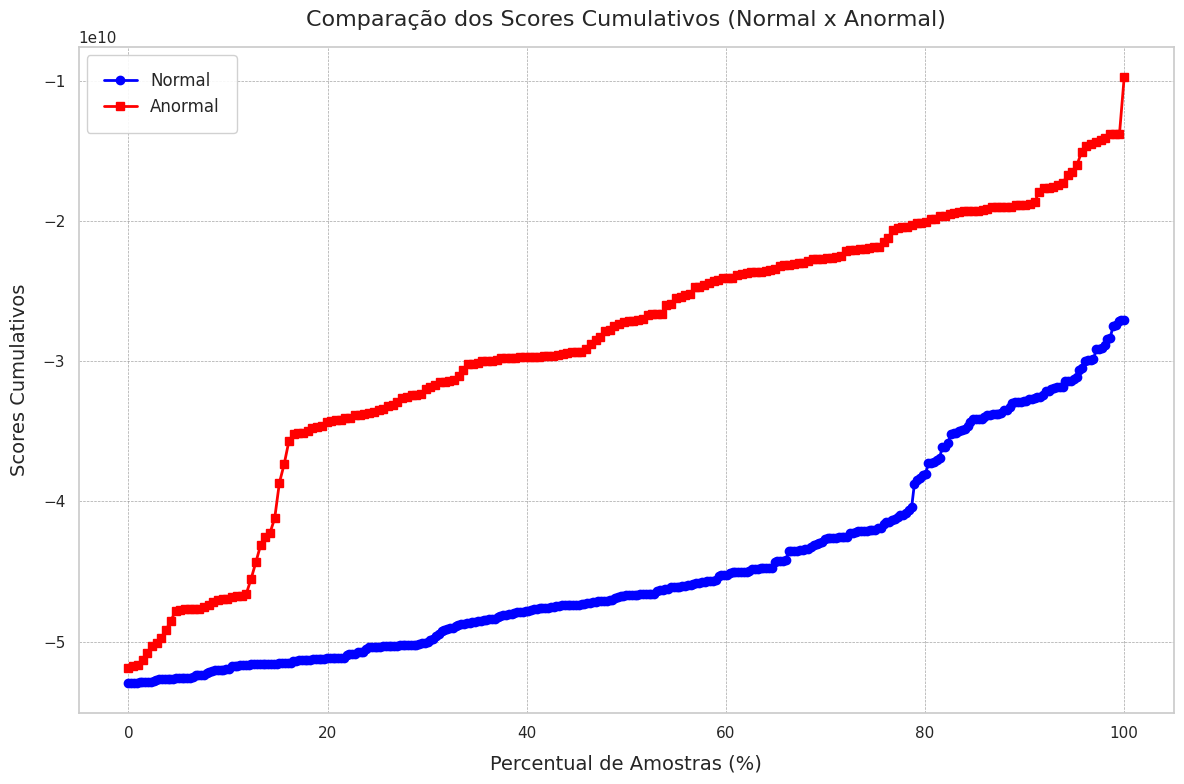

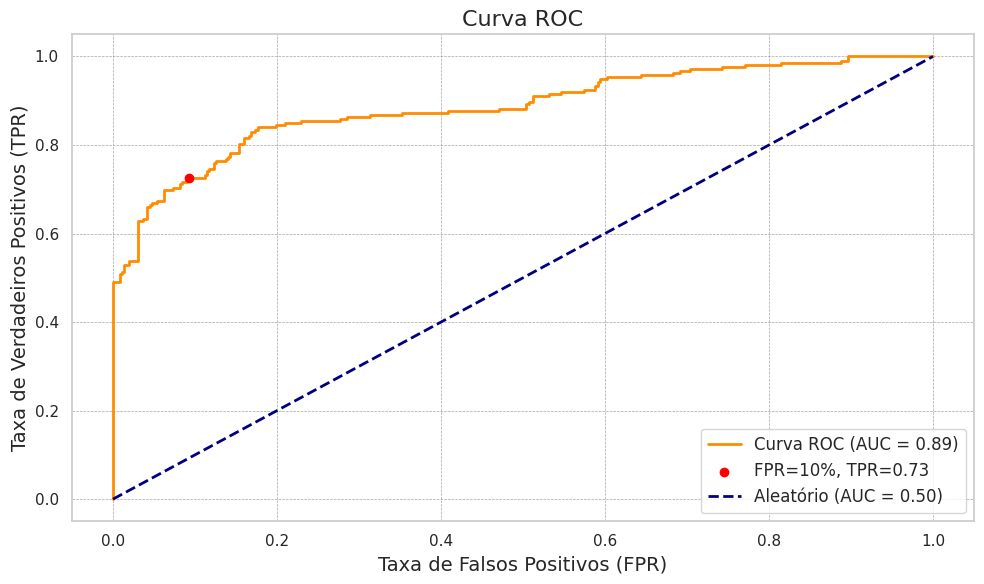

Taxa de detecção para FPR=10%: 72.64%
Tempo total de execução: 684.62 segundos


Iterações de treinamento:   0%|          | 0/15 [00:00<?, ?it/s]

primeiros valores de matriz_detetores: [[225  13  81  11 171 281 242  75  28  95 207   3 235  62 284 179  21 294
  154 107  77 104  24 252 151  59   4  78 209  16  89 300 253  52 159 290
  187 125 212  33  84 184   1 176  69  93  97 197 262 173 131  61 288  98
   96  67 198 273 122  35 279 134 161 259  34  92  57 231 106 174  88 162
   42 229 289  22  19 272 239  60 224 255  37 126   6 190 285  50 101 105
  169 168  85 240 256 111 117 127 238 251 112 270  87 260 164 191 257 216
  210 124  12 152   9 102 141  94  49 165 250 120 188 223  23 258 148  51
  206 237 243  46 185 114 109 195  30 121 274 178 145 219 276  10   5  71
  233 138  91 222  54  79 213 146 221 211  65   7 115 155  17   2  36 149
  156 287  47  64 248 192 263 177 297  14 202 182 143 268 261 234 160 214
    8 267 293 299 153 181 264 158 204  80 286 232 144  15 183 116 118 236
  163 166  31 269 220 157 180 283 201  55 167 199 203 295 128 230 228  29
  140 100 227 278  44  66 282 271  99 137 291 266 218 123 133 147 136 208


Iterações de treinamento:   7%|▋         | 1/15 [00:44<10:18, 44.15s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([  -3,   62,  252, -151,  -52,  212,  -84,  262, -173,  131,  161,
         92, -101, -111,  191,   12, -223,   23,  121,  274, -182, -143,
       -232, -283, -203,   44,   73, -245,  -32, -292]))]
primeiros valores de scores_normal_80: [[4.25516056e+08 5.18801579e+08 1.48415014e+08 6.25533430e+08
  3.20385730e+07 7.92555879e+08 4.96485134e+08 6.73142300e+06
  8.31962332e+08 5.24885253e+08 8.43313472e+08 1.45630067e+08
  5.35418612e+08 1.82233740e+08 3.63026517e+08 8.53248588e+08
  1.35766673e+08 5.65003273e+08 2.78376008e+08 5.41472112e+08
  8.94717740e+07 1.62998330e+08 6.44575551e+08 1.61672353e+08
  5.94268386e+08 8.04047225e+08 9.89074712e+08 2.06605514e+08
  6.23370214e+08 1.06537377e+09 1.03394649e+08 7.19741917e+08
  4.67231264e+08 7.47135900e+08 2.78359581e+08 6.62387896e+08
  7.15369368e+08 2.94463600e+08 5.17810445e+08 3.22367133e+08
  7.88857103e+08 1.05812897e+09 6.87850842e+08 8.49332554e+08
  1.15850010e+08 2.3195528


Iterações de treinamento:  13%|█▎        | 2/15 [01:30<09:49, 45.32s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 173,  212,  121,   52,  -32,  232,    3,  -12, -203, -292, -223,
        182,  161,   92, -111,  -62, -131, -283,  143, -101,   44, -151,
        274,   73, -245,  252,   84,   23, -191,  262]))]
primeiros valores de scores_normal_80: [[1.03226032e+09 7.88945111e+08 4.60434777e+08 1.02959375e+09
  8.61695137e+08 1.04865458e+09 1.07318353e+09 5.32779739e+08
  1.06883741e+09 4.36017313e+08 8.59707681e+08 1.06537377e+09
  4.63330566e+08 7.99561344e+08 1.00800998e+09 3.93757132e+08
  3.22413688e+08 7.85284031e+08 6.00771005e+08 1.05812897e+09
  6.67811737e+08 9.35443135e+08 7.69210469e+08 8.05235587e+08
  1.00335537e+09 1.06980381e+09 6.59867963e+08 3.83391793e+08
  7.88248652e+08 1.00577890e+09 5.20412315e+08 1.01645069e+09
  9.39173403e+08 1.07356861e+09 3.33791344e+08 1.91432812e+08
  3.85233576e+08 7.89843839e+08 8.03746192e+08 8.01089229e+08
  7.63635848e+08 3.64239196e+08 6.61038044e+08 4.66201950e+08
  2.40287464e+08 6.7322215


Iterações de treinamento:  20%|██        | 3/15 [02:16<09:08, 45.74s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  1.06400289e+09 1.06325627e+09 2.67474511e+08 1.06014017e+09
  5.37944620e+07 1.03389563e+09 8.61695137e+08 1.04865458e+09
  1.07318353e+09 5.32779739e+08 9.88164831e+08 1.05280050e+09
  4.89729985e+08 1.06537377e+09 8.59707681e+08 1.06883741e+09
  4.36017313e+08 1.01092538e+09 7.99561344e+08 8.48733056e+08
  7.93534395e+08 2.48123961e+08 4.63330566e+08 1.06108647e+09
  3.93757132e+08 1.01066593e+09 1.03349582e+09 1.00800998e+09
  6.00771005e+08 7.85284031e+08 3.22413688e+08 7.81981825e+08
  1.05812897e+09 1.05262237e+09 9.37219142e+08 4.23790297e+08
  1.02955090e+09 8.5468690


Iterações de treinamento:  27%|██▋       | 4/15 [03:02<08:25, 45.98s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 5.37944620e+07 1.03389563e+09
  1.06014017e+09 1.06014017e+09 5.37944620e+07 1.03389563e+09
  8.61695137e+08 5.32779739e+08 1.07318353e+09 1.04865458e+09
  9.88164831e+08 1.05280050e+09 9.88164831e+08 1.05280050e+09
  1.01092538e+09 4.36017313e+08 1.06883741e+09 8.59707681e+08
  1.06537377e+09 4.89729985e+08 1.01092538e+09 4.89729985e+08
  7.93534395e+08 2.48123961e+08 7.93534395e+08 1.06108647e+09
  1.06108647e+09 7.9956134


Iterações de treinamento:  33%|███▎      | 5/15 [03:48<07:40, 46.00s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 2.67474511e+08
  1.06325627e+09 1.06325627e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 1.06014017e+09 5.37944620e+07 1.06014017e+09
  1.03389563e+09 5.37944620e+07 1.03389563e+09 1.06014017e+09
  1.03389563e+09 5.37944620e+07 8.61695137e+08 5.32779739e+08
  1.07318353e+09 1.04865458e+09 9.88164831e+08 1.05280050e+09
  9.88164831e+08 1.05280050e+09 9.88164831e+08 1.05280050e+09
  4.36017313e+08 1.0109253


Iterações de treinamento:  40%|████      | 6/15 [04:35<06:54, 46.06s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  2.67474511e+08 1.06325627e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 2.67474511e+08 1.06325627e+09
  1.03389563e+09 5.37944620e+07 1.03389563e+09 5.37944620e+07
  1.03389563e+09 1.06014017e+09 1.06014017e+09 1.03389563e+09
  1.06014017e+09 5.37944620e+07 1.06014017e+09 5.37944620e+07
  8.61695137e+08 5.3277973


Iterações de treinamento:  47%|████▋     | 7/15 [05:20<06:07, 45.92s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06325627e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 1.06325627e+09 2.67474511e+08 1.03389563e+09
  5.37944620e+07 1.03389563e+09 5.37944620e+07 1.06014017e+09
  5.37944620e+07 1.0601401


Iterações de treinamento:  53%|█████▎    | 8/15 [06:07<05:24, 46.30s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 1.06325627e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.6747451


Iterações de treinamento:  60%|██████    | 9/15 [06:53<04:37, 46.22s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.6747451


Iterações de treinamento:  67%|██████▋   | 10/15 [07:40<03:51, 46.34s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06325627e+09 2.6747451


Iterações de treinamento:  73%|███████▎  | 11/15 [08:27<03:06, 46.53s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.0640028


Iterações de treinamento:  80%|████████  | 12/15 [09:13<02:19, 46.35s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.0640028


Iterações de treinamento:  87%|████████▋ | 13/15 [10:00<01:32, 46.47s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.8169310


Iterações de treinamento:  93%|█████████▎| 14/15 [10:46<00:46, 46.34s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.8169310


Iterações de treinamento: 100%|██████████| 15/15 [11:32<00:00, 46.14s/it]


primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.8169310

Calculando scores: 100%|██████████| 357/357 [00:00<00:00, 616.84it/s]


primeiros valores de scores_normal_100: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08]]
primeiros valores de sublists_anomalous: [(0, 0, array([ 162,  133, -279,  104,  192,  206,   -5, -112,   77,  -58, -154,
        -67,  227, -173, -266,   34, -183, -246,   25,  -87,

Calculando scores: 100%|██████████| 212/212 [00:00<00:00, 720.44it/s]


primeiros valores de scores_anomalous: [[9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 1.03787778e+09 3.93617022e+08
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  9.21595784e+08 7.46935867e+08 1.76347690e+08 1.76347690e+08
  1.76347690e+08 1.76347690e+08]]
primeiros valores de negative_scores_normal: [[-1.03302862e+09 -1.03302862e+09 -1.03302862e+09 -1.03302862e+09
  -1.03302862e+09 -1.03302862e+09 -1.03302862e+09 -1.03302862e+09
  -1.0

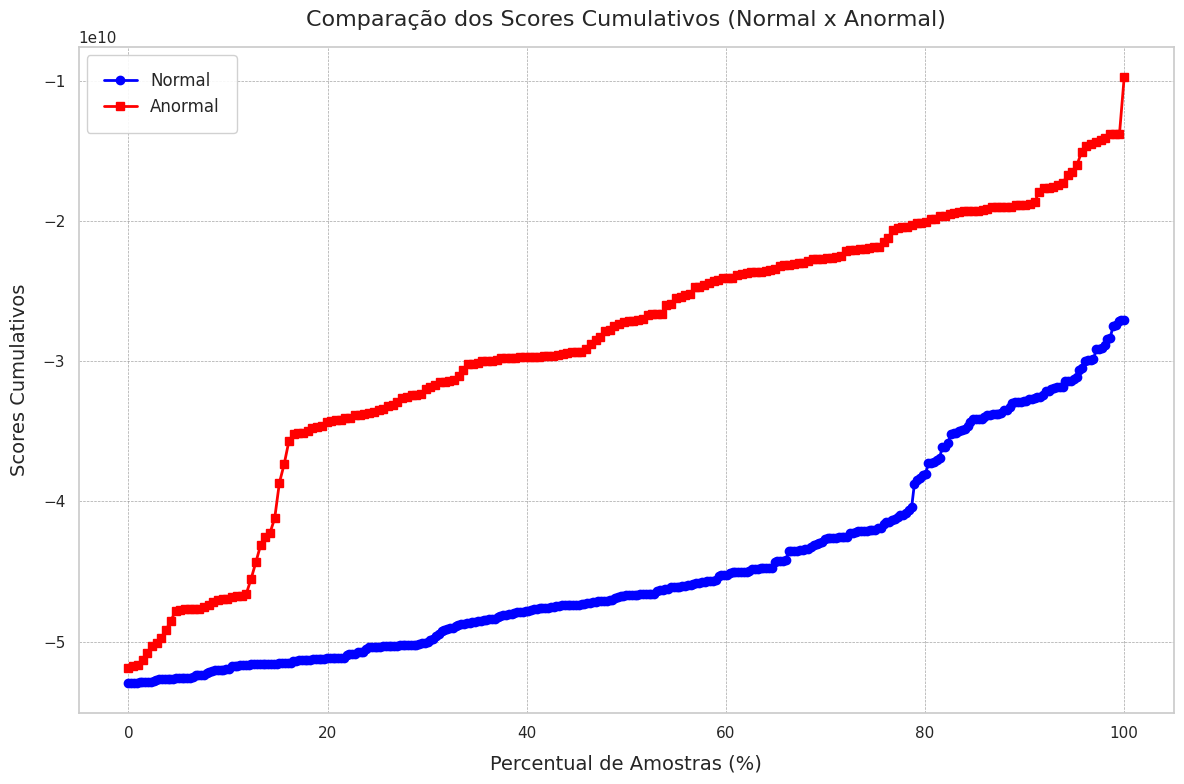

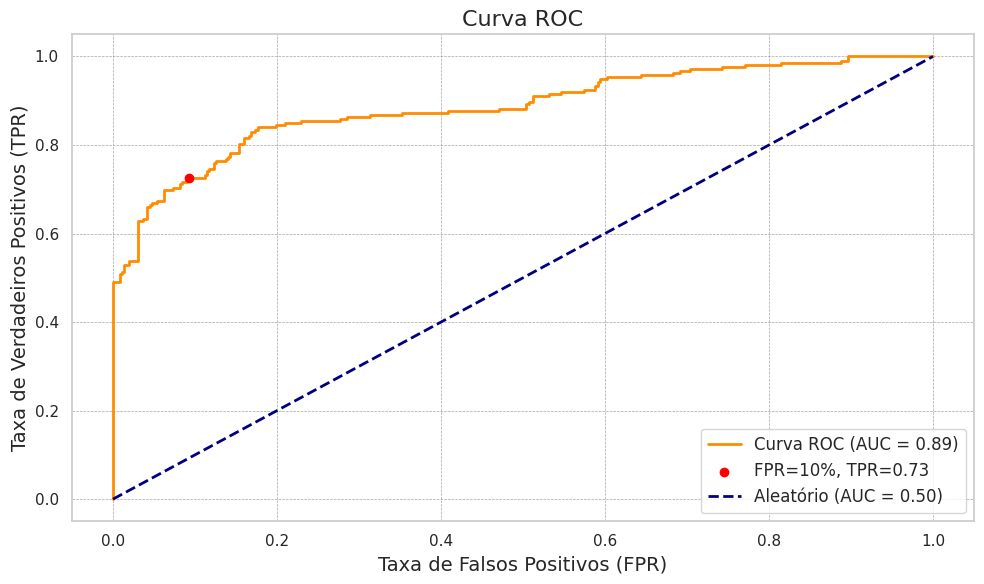

Taxa de detecção para FPR=10%: 72.64%
Tempo total de execução: 700.20 segundos


Iterações de treinamento:   0%|          | 0/15 [00:00<?, ?it/s]

primeiros valores de matriz_detetores: [[225  13  81  11 171 281 242  75  28  95 207   3 235  62 284 179  21 294
  154 107  77 104  24 252 151  59   4  78 209  16  89 300 253  52 159 290
  187 125 212  33  84 184   1 176  69  93  97 197 262 173 131  61 288  98
   96  67 198 273 122  35 279 134 161 259  34  92  57 231 106 174  88 162
   42 229 289  22  19 272 239  60 224 255  37 126   6 190 285  50 101 105
  169 168  85 240 256 111 117 127 238 251 112 270  87 260 164 191 257 216
  210 124  12 152   9 102 141  94  49 165 250 120 188 223  23 258 148  51
  206 237 243  46 185 114 109 195  30 121 274 178 145 219 276  10   5  71
  233 138  91 222  54  79 213 146 221 211  65   7 115 155  17   2  36 149
  156 287  47  64 248 192 263 177 297  14 202 182 143 268 261 234 160 214
    8 267 293 299 153 181 264 158 204  80 286 232 144  15 183 116 118 236
  163 166  31 269 220 157 180 283 201  55 167 199 203 295 128 230 228  29
  140 100 227 278  44  66 282 271  99 137 291 266 218 123 133 147 136 208


Iterações de treinamento:   7%|▋         | 1/15 [00:44<10:25, 44.71s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([  -3,   62,  252, -151,  -52,  212,  -84,  262, -173,  131,  161,
         92, -101, -111,  191,   12, -223,   23,  121,  274, -182, -143,
       -232, -283, -203,   44,   73, -245,  -32, -292]))]
primeiros valores de scores_normal_80: [[4.25516056e+08 5.18801579e+08 1.48415014e+08 6.25533430e+08
  3.20385730e+07 7.92555879e+08 4.96485134e+08 6.73142300e+06
  8.31962332e+08 5.24885253e+08 8.43313472e+08 1.45630067e+08
  5.35418612e+08 1.82233740e+08 3.63026517e+08 8.53248588e+08
  1.35766673e+08 5.65003273e+08 2.78376008e+08 5.41472112e+08
  8.94717740e+07 1.62998330e+08 6.44575551e+08 1.61672353e+08
  5.94268386e+08 8.04047225e+08 9.89074712e+08 2.06605514e+08
  6.23370214e+08 1.06537377e+09 1.03394649e+08 7.19741917e+08
  4.67231264e+08 7.47135900e+08 2.78359581e+08 6.62387896e+08
  7.15369368e+08 2.94463600e+08 5.17810445e+08 3.22367133e+08
  7.88857103e+08 1.05812897e+09 6.87850842e+08 8.49332554e+08
  1.15850010e+08 2.3195528


Iterações de treinamento:  13%|█▎        | 2/15 [01:32<10:01, 46.31s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 173,  212,  121,   52,  -32,  232,    3,  -12, -203, -292, -223,
        182,  161,   92, -111,  -62, -131, -283,  143, -101,   44, -151,
        274,   73, -245,  252,   84,   23, -191,  262]))]
primeiros valores de scores_normal_80: [[1.03226032e+09 7.88945111e+08 4.60434777e+08 1.02959375e+09
  8.61695137e+08 1.04865458e+09 1.07318353e+09 5.32779739e+08
  1.06883741e+09 4.36017313e+08 8.59707681e+08 1.06537377e+09
  4.63330566e+08 7.99561344e+08 1.00800998e+09 3.93757132e+08
  3.22413688e+08 7.85284031e+08 6.00771005e+08 1.05812897e+09
  6.67811737e+08 9.35443135e+08 7.69210469e+08 8.05235587e+08
  1.00335537e+09 1.06980381e+09 6.59867963e+08 3.83391793e+08
  7.88248652e+08 1.00577890e+09 5.20412315e+08 1.01645069e+09
  9.39173403e+08 1.07356861e+09 3.33791344e+08 1.91432812e+08
  3.85233576e+08 7.89843839e+08 8.03746192e+08 8.01089229e+08
  7.63635848e+08 3.64239196e+08 6.61038044e+08 4.66201950e+08
  2.40287464e+08 6.7322215


Iterações de treinamento:  20%|██        | 3/15 [02:19<09:21, 46.82s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  1.06400289e+09 1.06325627e+09 2.67474511e+08 1.06014017e+09
  5.37944620e+07 1.03389563e+09 8.61695137e+08 1.04865458e+09
  1.07318353e+09 5.32779739e+08 9.88164831e+08 1.05280050e+09
  4.89729985e+08 1.06537377e+09 8.59707681e+08 1.06883741e+09
  4.36017313e+08 1.01092538e+09 7.99561344e+08 8.48733056e+08
  7.93534395e+08 2.48123961e+08 4.63330566e+08 1.06108647e+09
  3.93757132e+08 1.01066593e+09 1.03349582e+09 1.00800998e+09
  6.00771005e+08 7.85284031e+08 3.22413688e+08 7.81981825e+08
  1.05812897e+09 1.05262237e+09 9.37219142e+08 4.23790297e+08
  1.02955090e+09 8.5468690


Iterações de treinamento:  27%|██▋       | 4/15 [03:07<08:38, 47.14s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 5.37944620e+07 1.03389563e+09
  1.06014017e+09 1.06014017e+09 5.37944620e+07 1.03389563e+09
  8.61695137e+08 5.32779739e+08 1.07318353e+09 1.04865458e+09
  9.88164831e+08 1.05280050e+09 9.88164831e+08 1.05280050e+09
  1.01092538e+09 4.36017313e+08 1.06883741e+09 8.59707681e+08
  1.06537377e+09 4.89729985e+08 1.01092538e+09 4.89729985e+08
  7.93534395e+08 2.48123961e+08 7.93534395e+08 1.06108647e+09
  1.06108647e+09 7.9956134


Iterações de treinamento:  33%|███▎      | 5/15 [03:55<07:57, 47.71s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 2.67474511e+08
  1.06325627e+09 1.06325627e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 1.06014017e+09 5.37944620e+07 1.06014017e+09
  1.03389563e+09 5.37944620e+07 1.03389563e+09 1.06014017e+09
  1.03389563e+09 5.37944620e+07 8.61695137e+08 5.32779739e+08
  1.07318353e+09 1.04865458e+09 9.88164831e+08 1.05280050e+09
  9.88164831e+08 1.05280050e+09 9.88164831e+08 1.05280050e+09
  4.36017313e+08 1.0109253


Iterações de treinamento:  40%|████      | 6/15 [04:44<07:11, 47.91s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  2.67474511e+08 1.06325627e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 2.67474511e+08 1.06325627e+09
  1.03389563e+09 5.37944620e+07 1.03389563e+09 5.37944620e+07
  1.03389563e+09 1.06014017e+09 1.06014017e+09 1.03389563e+09
  1.06014017e+09 5.37944620e+07 1.06014017e+09 5.37944620e+07
  8.61695137e+08 5.3277973


Iterações de treinamento:  47%|████▋     | 7/15 [05:32<06:23, 47.88s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06325627e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 1.06325627e+09 2.67474511e+08 1.03389563e+09
  5.37944620e+07 1.03389563e+09 5.37944620e+07 1.06014017e+09
  5.37944620e+07 1.0601401


Iterações de treinamento:  53%|█████▎    | 8/15 [06:20<05:36, 48.09s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06325627e+09 2.67474511e+08
  2.67474511e+08 1.06325627e+09 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.6747451


Iterações de treinamento:  60%|██████    | 9/15 [07:08<04:48, 48.06s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06325627e+09
  2.67474511e+08 2.67474511e+08 1.06325627e+09 1.06325627e+09
  2.67474511e+08 2.6747451


Iterações de treinamento:  67%|██████▋   | 10/15 [07:56<04:00, 48.11s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06325627e+09 2.6747451


Iterações de treinamento:  73%|███████▎  | 11/15 [08:44<03:11, 47.88s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.06400289e+09 1.06400289e+09 1.06400289e+09
  1.06400289e+09 1.0640028


Iterações de treinamento:  80%|████████  | 12/15 [09:32<02:23, 47.96s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  1.06400289e+09 1.0640028


Iterações de treinamento:  87%|████████▋ | 13/15 [10:19<01:35, 47.71s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03226032e+09
  7.88945111e+08 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 4.60434777e+08
  1.02959375e+09 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.8169310


Iterações de treinamento:  93%|█████████▎| 14/15 [11:06<00:47, 47.60s/it]

primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03226032e+09 7.88945111e+08 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 4.60434777e+08 1.02959375e+09
  7.81693100e+08 7.81693100e+08 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.8169310


Iterações de treinamento: 100%|██████████| 15/15 [11:54<00:00, 47.65s/it]


primeiros valores de sublists_normal_80: [(0, 0, array([ 182,  232,  252,  143,   -3,   62,  223, -274, -121,  131, -283,
       -151,   52, -111,   73,  173,  -92,  -23, -292,  245,  -32, -212,
        -44, -262,   84,  161, -203, -101,  -12, -191]))]
primeiros valores de scores_normal_80: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03226032e+09 7.88945111e+08 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 4.60434777e+08 1.02959375e+09 7.81693100e+08
  7.81693100e+08 7.8169310

Calculando scores: 100%|██████████| 357/357 [00:00<00:00, 706.22it/s]


primeiros valores de scores_normal_100: [[1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03302866e+09 1.03302866e+09
  1.03302866e+09 1.03302866e+09 1.03226032e+09 7.88945111e+08
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.01580028e+09 1.01580028e+09
  1.01580028e+09 1.01580028e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  1.07072430e+09 1.07072430e+09 1.07072430e+09 1.07072430e+09
  4.60434777e+08 1.02959375e+09 7.81693100e+08 7.81693100e+08
  7.81693100e+08 7.81693100e+08]]
primeiros valores de sublists_anomalous: [(0, 0, array([ 162,  133, -279,  104,  192,  206,   -5, -112,   77,  -58, -154,
        -67,  227, -173, -266,   34, -183, -246,   25,  -87,

Calculando scores: 100%|██████████| 212/212 [00:00<00:00, 704.51it/s]


primeiros valores de scores_anomalous: [[9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 9.24994149e+08 9.24994149e+08
  9.24994149e+08 9.24994149e+08 1.03787778e+09 3.93617022e+08
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.34846100e+07 3.34846100e+07
  3.34846100e+07 3.34846100e+07 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  3.42193157e+08 3.42193157e+08 3.42193157e+08 3.42193157e+08
  9.21595784e+08 7.46935867e+08 1.76347690e+08 1.76347690e+08
  1.76347690e+08 1.76347690e+08]]
primeiros valores de negative_scores_normal: [[-1.03302862e+09 -1.03302862e+09 -1.03302862e+09 -1.03302862e+09
  -1.03302862e+09 -1.03302862e+09 -1.03302862e+09 -1.03302862e+09
  -1.0

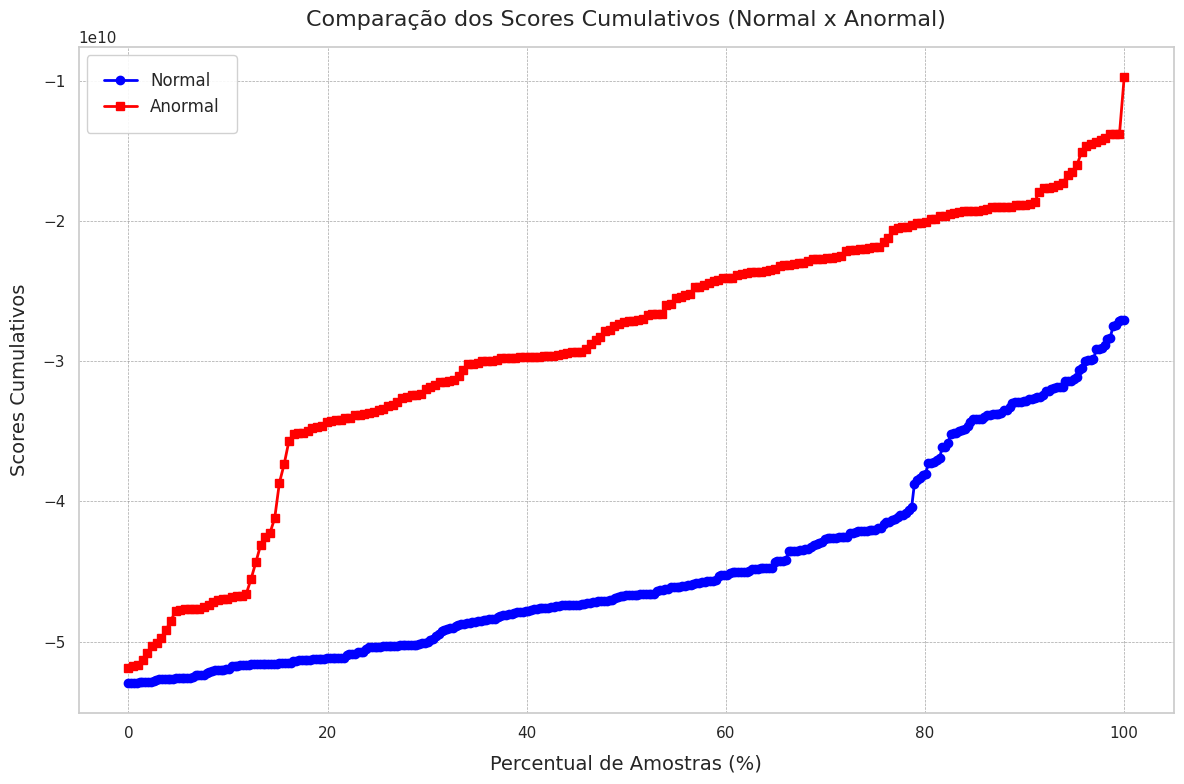

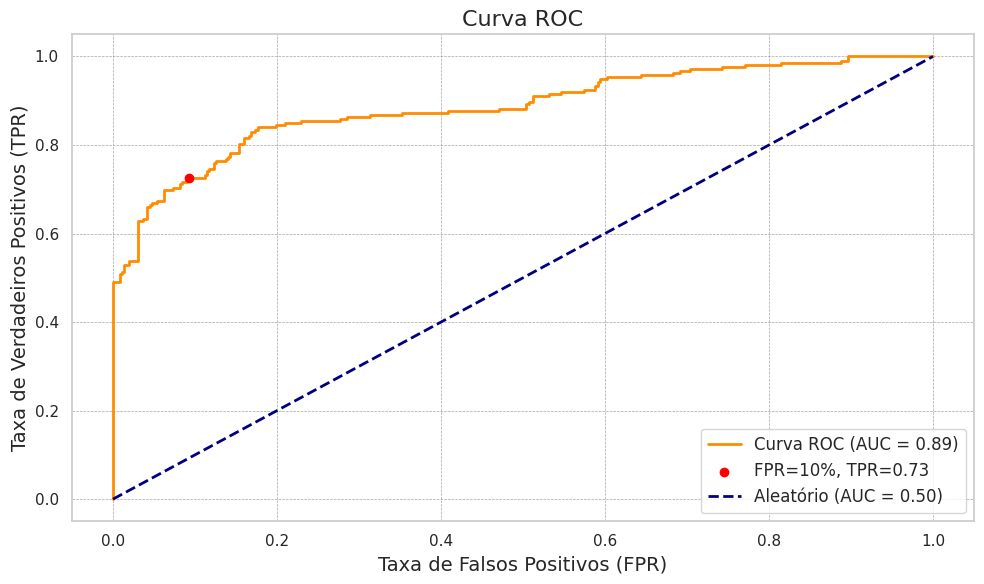

Taxa de detecção para FPR=10%: 72.64%
Tempo total de execução: 723.36 segundos


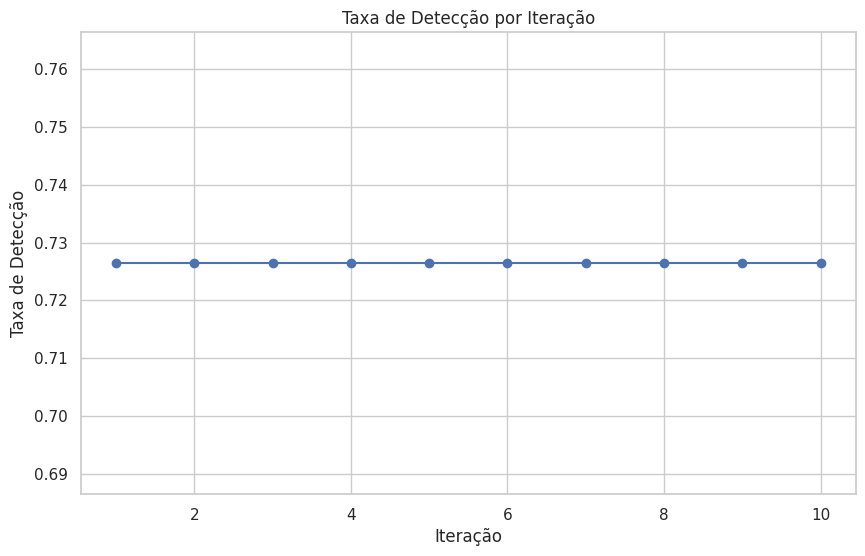

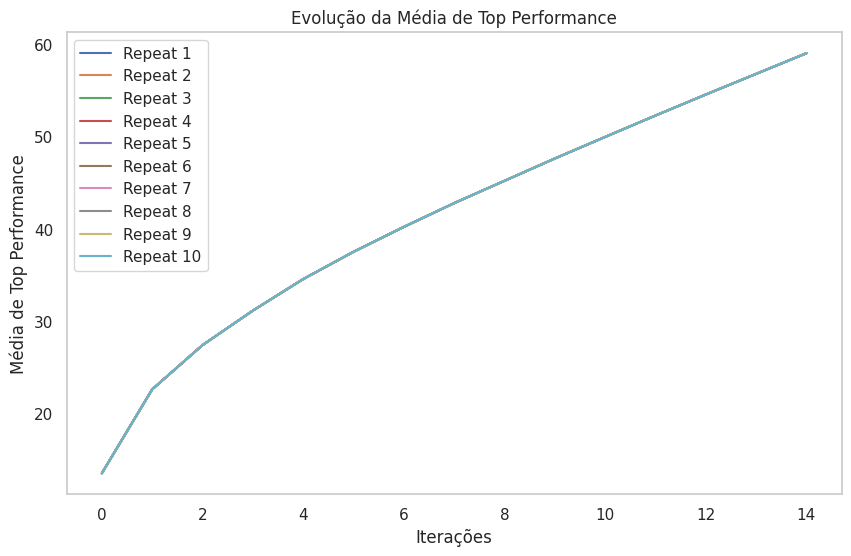

In [12]:
def main():
    start_time = time.time()

    # Parâmetros de treinamento
    NUM_ITERACOES = 15
    NUM_DETETORES_INICIAL = 1000
    NUM_DETETORES_MANTER = 50
    NUM_DETETORES_NOVOS = NUM_DETETORES_INICIAL - NUM_DETETORES_MANTER

    # Carregar dados normais e anômalos
    df_normal = load_data('breast_cancer_normal.xlsx')
    df_anomalous = load_data('breast_cancer_anomalous.xlsx')

    # Processar dados normais para seleção de detectores (80% das amostras)
    df_samples_normal_80 = select_samples(df_normal, percentage=0.8)

    # Inicializar melhores detectores e matrizes binárias
    best_detectors = np.array([])
    best_binary_matrices = np.array([])

    performance_evolution = []

    for iteracao in tqdm(range(NUM_ITERACOES), desc="Iterações de treinamento"):
        # Criar novos detectores e matrizes binárias
        if iteracao == 0:
            novos_detetores, novas_matrizes_binarias = criar_matriz_detetores(NUM_DETETORES_INICIAL)
        else:
            novos_detetores, novas_matrizes_binarias = criar_matriz_detetores(NUM_DETETORES_NOVOS)

        # Combinar com os melhores detectores da iteração anterior
        matriz_detetores = np.vstack([best_detectors, novos_detetores]) if best_detectors.size else novos_detetores
        matriz_binaria = np.vstack([best_binary_matrices, novas_matrizes_binarias]) if best_binary_matrices.size else novas_matrizes_binarias
        print(f"primeiros valores de matriz_detetores: {matriz_detetores[:1]}")
        print(f"primeiros valores de matriz_binaria: {matriz_binaria[:1]}")

        # Criar sublistas e calcular scores
        sublists_normal_80 = create_sublist(df_samples_normal_80.values, matriz_detetores, matriz_binaria)
        scores_normal_80 = calculate_all_scores(df_samples_normal_80, matriz_detetores, sublists_normal_80)
        print(f"primeiros valores de sublists_normal_80: {sublists_normal_80[:1]}")
        print(f"primeiros valores de scores_normal_80: {scores_normal_80[:1]}")

        # Selecionar top detectores
        top_indices, top_detectors, top_binary_matrices, top_performance = select_top_detectors(scores_normal_80, matriz_detetores, matriz_binaria, top_n=NUM_DETETORES_MANTER)

        # Salvar os resultados
        #np.save('top_60_detector_indices.npy', top_indices)
        #np.save('top_60_detectors.npy', top_detectors)
        #np.save('top_60_binary_matrices.npy', top_binary_matrices)
        #np.save('top_60_performance.npy', top_performance)
        print(f"top_30_detector_indices: {top_indices} para a iteração: {iteracao + 1}")
        print(f"top_30_detectors: {top_detectors} para a iteração: {iteracao + 1}")
        print(f"top_30_binary_matrices: {top_binary_matrices} para a iteração: {iteracao + 1}")
        print(f"top_30_performance: {top_performance} para a iteração: {iteracao + 1}")

        print(f"Top 30 detectores selecionados e salvos.")
        print(f"Forma dos top detectores: {top_detectors.shape} para a iteração: {iteracao + 1}")
        print(f"Forma das top matrizes binárias: {top_binary_matrices.shape} para a iteração: {iteracao + 1}")

        print(f"primeiros valores de selected_detectors: {top_detectors[:1]} para a iteração: {iteracao + 1}")
        print(f"primeiros valores de selected_binary_matrices: {top_binary_matrices[:1]} para a iteração: {iteracao + 1}")

        # Atualizar melhores detectores
        best_detectors = top_detectors
        best_binary_matrices = top_binary_matrices
        performance_evolution.append(np.mean(top_performance))

        print(f"Iteração {iteracao + 1} concluída. Performance média dos top detectores: {np.mean(top_performance):.2f}")

    # Salvar os melhores detectores e matrizes binárias
    np.save('best_detectors.npy', best_detectors)
    np.save('best_binary_matrices.npy', best_binary_matrices)
    save_to_excel('melhores_detetores_e_binarios.xlsx', best_detectors, best_binary_matrices)

    print(f"Treino concluído. {NUM_DETETORES_MANTER} melhores detectores selecionados e salvos.")

    #### Testagem ####--> Fiquei aqui

    # Processar dados normais com 100% das amostras
    sublists_normal_100 = create_sublist(df_normal.values, best_detectors,best_binary_matrices)
    print(f"primeiros valores de sublists_normal_100: {sublists_normal_100[:1]}")
    with open('sublists_normal_100.pkl', 'wb') as f:
        pickle.dump(sublists_normal_100, f)

    # Calcular scores normais com 100% das amostras
    scores_normal_100 = calculate_all_scores(df_normal, best_detectors, sublists_normal_100)
    np.save('todos_scores_normal_100.npy', scores_normal_100)
    print(f"primeiros valores de scores_normal_100: {scores_normal_100[:1]}")

    ### Validação ###

    # Processar dados anômalos
    sublists_anomalous = create_sublist(df_anomalous.values, best_detectors, best_binary_matrices)
    print(f"primeiros valores de sublists_anomalous: {sublists_anomalous[:1]}")
    with open('sublists_anormal.pkl', 'wb') as f:
        pickle.dump(sublists_anomalous, f)

    # Calcular os scores anomalos
    scores_anomalous = calculate_all_scores(df_anomalous, best_detectors, sublists_anomalous)
    np.save('todos_scores_anormal.npy', scores_anomalous)
    print(f"primeiros valores de scores_anomalous: {scores_anomalous[:1]}")


    # Transformar scores e calcular scores cumulativos
    negative_scores_normal = transform_to_negative_scores(scores_normal_100)
    negative_scores_anomalous = transform_to_negative_scores(scores_anomalous)
    m_normal = compute_cumulative_scores(negative_scores_normal)
    m_anomalous = compute_cumulative_scores(negative_scores_anomalous)
    np.save('comulative_normal.npy', m_normal)
    np.save('comulative_anormal.npy', m_anomalous)
    print(f"primeiros valores de negative_scores_normal: {negative_scores_normal[:1]}")
    print(f"primeiros valores de negative_scores_anormal: {negative_scores_anomalous[:1]}")
    print(f"primeiros valores de m_normal: {m_normal}")
    print(f"primeiros valores de m_anomalous: {m_anomalous}")

    # Calcular ROC e taxa de detecção
    fpr, tpr, thresholds, roc_auc, detection_rate = calculate_roc_and_detection_rate(m_normal, m_anomalous)
    print(f"primeiros valores de fpr: {fpr}")
    print(f"primeiros valores de tpr: {tpr}")
    print(f"primeiros valores de thresholds: {thresholds}")
    print(f"primeiros valores de roc_auc: {roc_auc}")
    print(f"primeiros valores de detection_rate: {detection_rate}")

    # Plotar gráficos
    plot_cumulative_scores(m_normal, m_anomalous)
    plot_roc_curve(fpr, tpr, roc_auc, detection_rate)

    # Imprimir taxa de detecção
    print(f"Taxa de detecção para FPR=10%: {detection_rate * 100:.2f}%")

    end_time = time.time()
    print(f"Tempo total de execução: {end_time - start_time:.2f} segundos")

    return detection_rate, performance_evolution

if __name__ == "__main__":
    n_repeats = 10  # Número de vezes que deseja repetir o main
    detection_rates, perfomance_evolutions = main_repeated(n_repeats)  # Coleta as taxas de detecção
    plot_detection_rates(detection_rates)  # Visualiza os resultados
    plot_performance_evolution(perfomance_evolutions)  # Visualiza a evolução da performance